All necessary information for setting up dtm: 
https://github.com/blei-lab/dtm/blob/master/README.md <- Compile binaries manually from Blei C++ 
https://github.com/piskvorky/gensim/blob/release-3.8.3/gensim/models/wrappers/dtmmodel.py As the gensim wrapper for Blei's DTM is not supported anymore: Compile dtm-code myself first. 

First: Create dtm command based on https://github.com/piskvorky/gensim/blob/release-3.8.3/gensim/models/wrappers/dtmmodel.py

In [1]:
import logging
import random
import warnings
import tempfile
import os
from subprocess import PIPE
import numpy as np

from gensim import utils, corpora, matutils
from gensim.utils import check_output

logger = logging.getLogger(__name__)


class DtmModel(utils.SaveLoad):
    """Python wrapper using `DTM implementation <https://github.com/magsilva/dtm/tree/master/bin>`_.

    Communication between DTM and Python takes place by passing around data files on disk and executing
    the DTM binary as a subprocess.

    Warnings
    --------
    This is **only** python wrapper for `DTM implementation <https://github.com/magsilva/dtm/tree/master/bin>`_,
    you need to install original implementation first and pass the path to binary to ``dtm_path``.

    """
    def __init__(self, dtm_path, corpus=None, time_slices=None, mode='fit', model='dtm', num_topics=100,
                 id2word=None, prefix=None, lda_sequence_min_iter=6, lda_sequence_max_iter=20, lda_max_em_iter=10,
                 alpha=0.01, top_chain_var=0.005, rng_seed=0, initialize_lda=True): # In limitations section: explain in 
        # detail what the relevant hyperparameters are: num_topics, alpha, and top_chain_var. 
        """

        Parameters
        ----------
        dtm_path : str
            Path to the dtm binary, e.g. `/home/username/dtm/dtm/main`.
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        time_slices : list of int
            Sequence of timestamps.
        mode : {'fit', 'time'}, optional
            Controls the mode of the mode: 'fit' is for training, 'time' for analyzing documents through time
            according to a DTM, basically a held out set.
        model : {'fixed', 'dtm'}, optional
            Control model that will be runned: 'fixed' is for DIM and 'dtm' for DTM.
        num_topics : int, optional
            Number of topics.
        id2word : :class:`~gensim.corpora.dictionary.Dictionary`, optional
            Mapping between tokens ids and words from corpus, if not specified - will be inferred from `corpus`.
        prefix : str, optional
            Prefix for produced temporary files.
        lda_sequence_min_iter : int, optional
             Min iteration of LDA.
        lda_sequence_max_iter : int, optional
            Max iteration of LDA.
        lda_max_em_iter : int, optional
             Max em optimization iterations in LDA.
        alpha : int, optional
            Hyperparameter that affects sparsity of the document-topics for the LDA models in each timeslice.
        top_chain_var : float, optional
            This hyperparameter controls one of the key aspect of topic evolution which is the speed at which
            these topics evolve. A smaller top_chain_var leads to similar word distributions over multiple timeslice.

        rng_seed : int, optional
             Random seed.
        initialize_lda : bool, optional
             If True - initialize DTM with LDA.

        """
        if not os.path.isfile(dtm_path):
            raise ValueError("dtm_path must point to the binary file, not to a folder")

        self.dtm_path = dtm_path
        self.id2word = id2word
        if self.id2word is None:
            logger.warning("no word id mapping provided; initializing from corpus, assuming identity")
            self.id2word = utils.dict_from_corpus(corpus)
            self.num_terms = len(self.id2word)
        else:
            self.num_terms = 0 if not self.id2word else 1 + max(self.id2word.keys())
        if self.num_terms == 0:
            raise ValueError("cannot compute DTM over an empty collection (no terms)")
        self.num_topics = num_topics

        try:
            lencorpus = len(corpus)
        except TypeError:
            logger.warning("input corpus stream has no len(); counting documents")
            lencorpus = sum(1 for _ in corpus)
        if lencorpus == 0:
            raise ValueError("cannot compute DTM over an empty corpus")
        if model == "fixed" and any(not text for text in corpus):
            raise ValueError("""There is a text without words in the input corpus.
                    This breaks method='fixed' (The DIM model).""")
        if lencorpus != sum(time_slices):
            raise ValueError(
                "mismatched timeslices %{slices} for corpus of len {clen}"
                .format(slices=sum(time_slices), clen=lencorpus)
            )
        self.lencorpus = lencorpus
        if prefix is None:
            rand_prefix = hex(random.randint(0, 0xffffff))[2:] + '_'
            prefix = os.path.join(tempfile.gettempdir(), rand_prefix)

        self.prefix = prefix
        self.time_slices = time_slices
        self.lda_sequence_min_iter = int(lda_sequence_min_iter)
        self.lda_sequence_max_iter = int(lda_sequence_max_iter)
        self.lda_max_em_iter = int(lda_max_em_iter)
        self.alpha = alpha
        self.top_chain_var = top_chain_var
        self.rng_seed = rng_seed
        self.initialize_lda = str(initialize_lda).lower()

        self.lambda_ = None
        self.obs_ = None
        self.lhood_ = None
        self.gamma_ = None
        self.init_alpha = None
        self.init_beta = None
        self.init_ss = None
        self.em_steps = []
        self.influences_time = []

        if corpus is not None:
            self.train(corpus, time_slices, mode, model)

    def fout_liklihoods(self):
        """Get path to temporary lhood data file.

        Returns
        -------
        str
            Path to lhood data file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'lhoods.dat'

    def fout_gamma(self):
        """Get path to temporary gamma data file.

        Returns
        -------
        str
            Path to gamma data file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'gam.dat'

    def fout_prob(self):
        """Get template of path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'topic-{i}-var-e-log-prob.dat'

    def fout_observations(self):
        """Get template of path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'topic-{i}-var-obs.dat'

    def fout_influence(self):
        """Get template of path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'influence_time-{i}'

    def foutname(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out'

    def fem_steps(self):
        """Get path to temporary em_step data file.

        Returns
        -------
        str
            Path to em_step data file.

        """
        return self.prefix + 'train_out/' + 'em_log.dat'

    def finit_alpha(self):
        """Get path to initially trained lda alpha file.

        Returns
        -------
        str
            Path to initially trained lda alpha file.

        """
        return self.prefix + 'train_out/' + 'initial-lda.alpha'

    def finit_beta(self):
        """Get path to initially trained lda beta file.

        Returns
        -------
        str
            Path to initially trained lda beta file.

        """
        return self.prefix + 'train_out/' + 'initial-lda.beta'

    def flda_ss(self):
        """Get path to initial lda binary file.

        Returns
        -------
        str
            Path to initial lda binary file.

        """
        return self.prefix + 'train_out/' + 'initial-lda-ss.dat'

    def fcorpustxt(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to multiple train binary file.

        """
        return self.prefix + 'train-mult.dat'

    def fcorpus(self):
        """Get path to corpus file.

        Returns
        -------
        str
            Path to corpus file.

        """
        return self.prefix + 'train'

    def ftimeslices(self):
        """Get path to time slices binary file.

        Returns
        -------
        str
            Path to time slices binary file.

        """
        return self.prefix + 'train-seq.dat'

    def convert_input(self, corpus, time_slices):
        """Convert corpus into LDA-C format by :class:`~gensim.corpora.bleicorpus.BleiCorpus` and save to temp file.
        Path to temporary file produced by :meth:`~gensim.models.wrappers.dtmmodel.DtmModel.ftimeslices`.

        Parameters
        ----------
        corpus : iterable of iterable of (int, float)
            Corpus in BoW format.
        time_slices : list of int
            Sequence of timestamps.

        """
        logger.info("serializing temporary corpus to %s", self.fcorpustxt())
        # write out the corpus in a file format that DTM understands:
        corpora.BleiCorpus.save_corpus(self.fcorpustxt(), corpus)

        with utils.open(self.ftimeslices(), 'wb') as fout:
            fout.write(utils.to_utf8(str(len(self.time_slices)) + "\n"))
            for sl in time_slices:
                fout.write(utils.to_utf8(str(sl) + "\n"))

    def train(self, corpus, time_slices, mode, model):
        """Train DTM model.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        time_slices : list of int
            Sequence of timestamps.
        mode : {'fit', 'time'}, optional
            Controls the mode of the mode: 'fit' is for training, 'time' for analyzing documents through time
            according to a DTM, basically a held out set.
        model : {'fixed', 'dtm'}, optional
            Control model that will be runned: 'fixed' is for DIM and 'dtm' for DTM.

        """
        self.convert_input(corpus, time_slices)

        arguments = \
            "--ntopics={p0} --model={mofrl}  --mode={p1} --initialize_lda={p2} --corpus_prefix={p3} " \
            "--outname={p4} --alpha={p5}".format(
                p0=self.num_topics, mofrl=model, p1=mode, p2=self.initialize_lda,
                p3=self.fcorpus(), p4=self.foutname(), p5=self.alpha
            )

        params = \
            "--lda_max_em_iter={p0} --lda_sequence_min_iter={p1}  --lda_sequence_max_iter={p2} " \
            "--top_chain_var={p3} --rng_seed={p4} ".format(
                p0=self.lda_max_em_iter, p1=self.lda_sequence_min_iter, p2=self.lda_sequence_max_iter,
                p3=self.top_chain_var, p4=self.rng_seed
            )

        arguments = arguments + " " + params
        logger.info("training DTM with args %s", arguments)

        cmd = [self.dtm_path] + arguments.split()
        logger.info("Running command %s", cmd)
        check_output(args=cmd, stderr=PIPE)

        self.em_steps = np.loadtxt(self.fem_steps())
        self.init_ss = np.loadtxt(self.flda_ss())

        if self.initialize_lda:
            self.init_alpha = np.loadtxt(self.finit_alpha())
            self.init_beta = np.loadtxt(self.finit_beta())

        self.lhood_ = np.loadtxt(self.fout_liklihoods())

        # document-topic proportions
        self.gamma_ = np.loadtxt(self.fout_gamma())
        # cast to correct shape, gamme[5,10] is the proprtion of the 10th topic
        # in doc 5
        self.gamma_.shape = (self.lencorpus, self.num_topics)
        # normalize proportions
        self.gamma_ /= self.gamma_.sum(axis=1)[:, np.newaxis]

        self.lambda_ = np.zeros((self.num_topics, self.num_terms * len(self.time_slices)))
        self.obs_ = np.zeros((self.num_topics, self.num_terms * len(self.time_slices)))

        for t in range(self.num_topics):
            topic = "%03d" % t
            self.lambda_[t, :] = np.loadtxt(self.fout_prob().format(i=topic))
            self.obs_[t, :] = np.loadtxt(self.fout_observations().format(i=topic))
        # cast to correct shape, lambda[5,10,0] is the proportion of the 10th
        # topic in doc 5 at time 0
        self.lambda_.shape = (self.num_topics, self.num_terms, len(self.time_slices))
        self.obs_.shape = (self.num_topics, self.num_terms, len(self.time_slices))
        # extract document influence on topics for each time slice
        # influences_time[0] , influences at time 0
        if model == 'fixed':
            for k, t in enumerate(self.time_slices):
                stamp = "%03d" % k
                influence = np.loadtxt(self.fout_influence().format(i=stamp))
                influence.shape = (t, self.num_topics)
                # influence[2,5] influence of document 2 on topic 5
                self.influences_time.append(influence)

    def print_topics(self, num_topics=10, times=5, num_words=10):
        """Alias for :meth:`~gensim.models.wrappers.dtmmodel.DtmModel.show_topics`.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        times : int, optional
            Number of times.
        num_words : int, optional
            Number of words.

        Returns
        -------
        list of str
            Topics as a list of strings

        """
        return self.show_topics(num_topics, times, num_words, log=True)

    def show_topics(self, num_topics=10, times=5, num_words=10, log=False, formatted=True):
        """Get the `num_words` most probable words for `num_topics` number of topics at 'times' time slices.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        times : int, optional
            Number of times.
        num_words : int, optional
            Number of words.
        log : bool, optional
            THIS PARAMETER WILL BE IGNORED.
        formatted : bool, optional
            If `True` - return the topics as a list of strings, otherwise as lists of (weight, word) pairs.

        Returns
        -------
        list of str
            Topics as a list of strings (if formatted=True) **OR**
        list of (float, str)
            Topics as list of (weight, word) pairs (if formatted=False)

        """
        if num_topics < 0 or num_topics >= self.num_topics:
            num_topics = self.num_topics
            chosen_topics = range(num_topics)
        else:
            num_topics = min(num_topics, self.num_topics)
            chosen_topics = range(num_topics)

        if times < 0 or times >= len(self.time_slices):
            times = len(self.time_slices)
            chosen_times = range(times)
        else:
            times = min(times, len(self.time_slices))
            chosen_times = range(times)

        shown = []
        for time in chosen_times:
            for i in chosen_topics:
                if formatted:
                    topic = self.print_topic(i, time, topn=num_words)
                else:
                    topic = self.show_topic(i, time, topn=num_words)
                shown.append(topic)
        return shown

    def show_topic(self, topicid, time, topn=50, num_words=None):
        """Get `num_words` most probable words for the given `topicid`.

        Parameters
        ----------
        topicid : int
            Id of topic.
        time : int
            Timestamp.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        list of (float, str)
            Sequence of probable words, as a list of `(word_probability, word)`.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        topics = self.lambda_[:, :, time]
        topic = topics[topicid]
        # likelihood to probability
        topic = np.exp(topic)
        # normalize to probability dist
        topic = topic / topic.sum()
        # sort according to prob
        bestn = matutils.argsort(topic, topn, reverse=True)
        beststr = [(topic[idx], self.id2word[idx]) for idx in bestn]
        return beststr

    def print_topic(self, topicid, time, topn=10, num_words=None):
        """Get the given topic, formatted as a string.

        Parameters
        ----------
        topicid : int
            Id of topic.
        time : int
            Timestamp.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        str
            The given topic in string format, like '0.132*someword + 0.412*otherword + ...'.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        return ' + '.join('%.3f*%s' % v for v in self.show_topic(topicid, time, topn=topn))

    def dtm_vis(self, corpus, time):
        """Get data specified by pyLDAvis format.

        Parameters
        ----------
        corpus : iterable of iterable of (int, float)
            Collection of texts in BoW format.
        time : int
            Sequence of timestamp.

        Notes
        -----
        All of these are needed to visualise topics for DTM for a particular time-slice via pyLDAvis.

        Returns
        -------
        doc_topic : numpy.ndarray
            Document-topic proportions.
        topic_term : numpy.ndarray
            Calculated term of topic suitable for pyLDAvis format.
        doc_lengths : list of int
            Length of each documents in corpus.
        term_frequency : numpy.ndarray
            Frequency of each word from vocab.
        vocab : list of str
            List of words from docpus.

        """
        topic_term = np.exp(self.lambda_[:, :, time]) / np.exp(self.lambda_[:, :, time]).sum()
        topic_term *= self.num_topics

        doc_topic = self.gamma_

        doc_lengths = [len(doc) for doc_no, doc in enumerate(corpus)]

        term_frequency = np.zeros(len(self.id2word))
        for doc_no, doc in enumerate(corpus):
            for pair in doc:
                term_frequency[pair[0]] += pair[1]

        vocab = [self.id2word[i] for i in range(0, len(self.id2word))]
        # returns numpy arrays for doc_topic proportions, topic_term proportions, and document_lengths, term_frequency.
        # these should be passed to the `pyLDAvis.prepare` method to visualise one time-slice of DTM topics.
        return doc_topic, topic_term, doc_lengths, term_frequency, vocab

    def dtm_coherence(self, time, num_words=20):
        """Get all topics of a particular time-slice without probability values for it to be used.
        For either "u_mass" or "c_v" coherence.

        Parameters
        ----------
        num_words : int
            Number of words.
        time : int
            Timestamp

        Returns
        -------
        coherence_topics : list of list of str
            All topics of a particular time-slice without probability values for it to be used.

        Warnings
        --------
        TODO: because of print format right now can only return for 1st time-slice, should we fix the coherence
        printing or make changes to the print statements to mirror DTM python?

        """
        coherence_topics = []
        for topic_no in range(0, self.num_topics):
            topic = self.show_topic(topicid=topic_no, time=time, num_words=num_words)
            coherence_topic = []
            for prob, word in topic:
                coherence_topic.append(word)
            coherence_topics.append(coherence_topic)

        return coherence_topics

Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_8033/1320740643.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


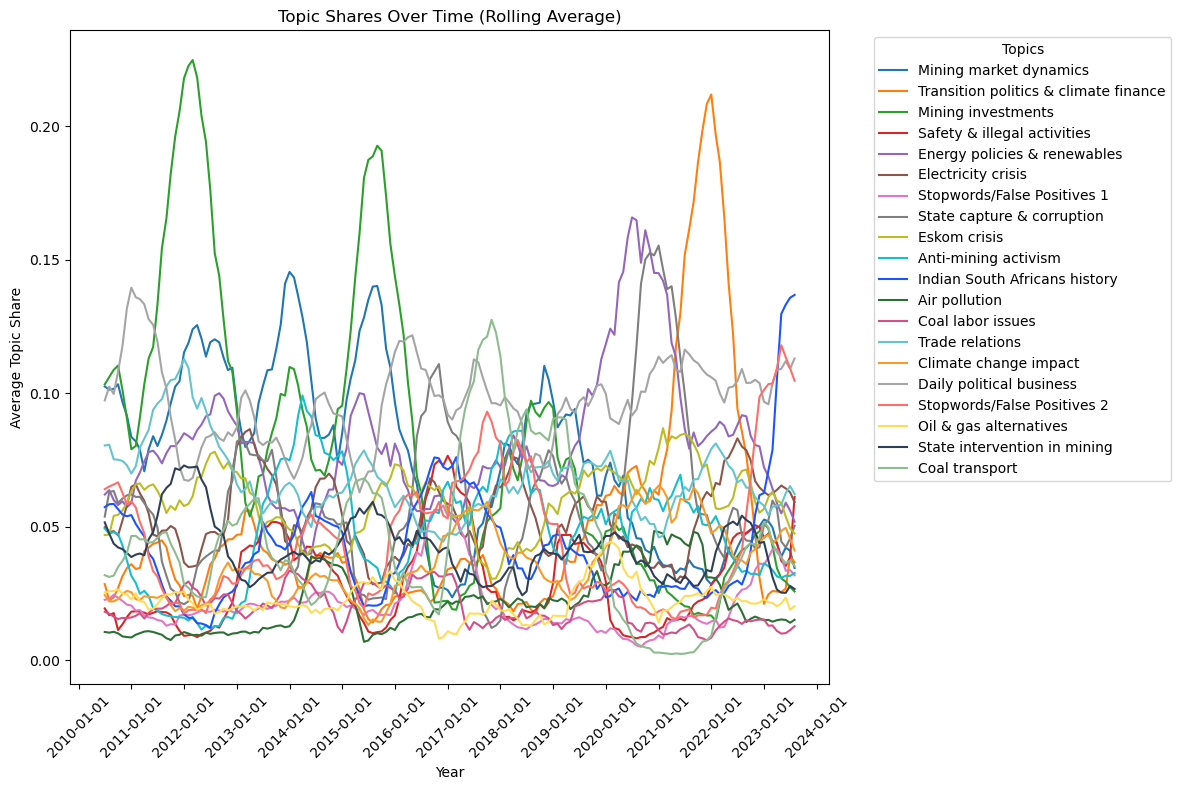

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import csv


#model
print("Loading model from disk...")
with open('dtm_model_subset_100_percent.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

#load my preprocessed dataset
print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

#print("Sampling subset of data...")
#sample_fraction = 0.2  # Adjust the fraction as needed
#df = df.sample(frac=sample_fraction, random_state=42)


# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]

num_topics = 20
topic_shares_over_time = np.zeros((len(time_slices), num_topics))


# New short topic names + classification
# Mining industry, Mining Communities, Climate and environment, Energy crisis, state role in mining 
topic_names = {
    0:  "Mining market dynamics",                # Mining Industry
    1:  "Transition politics & climate finance", # Climate change & Transition Politics
    2:  "Mining investments",                    # Mining Industry
    3:  "Safety & illegal activities",           # Mining Communities
    4:  "Energy policies & renewables",          # Climate change & Transition Politics / Energy Crisis
    5:  "Electricity crisis",                    # Energy Crisis
    6:  "Stopwords/False Positives 1",           # Don't Display
    7:  "State capture & corruption",            # State Role in Mining
    8:  "Eskom crisis",                          # Energy Crisis
    9:  "Anti-mining activism",                  # Mining Communities / Climate change & Transition Politics
    10: "Indian South Africans history",         # Don't Display
    11: "Air pollution",                         # Mining Communities
    12: "Coal labor issues",                     # Mining Industry
    13: "Trade relations",                       # State Role in Mining
    14: "Climate change impact",                 # Climate change & Transition Politics
    15: "Daily political business",              # State Role in Mining
    16: "Stopwords/False Positives 2",           # Don't Display
    17: "Oil & gas alternatives",                # Energy Crisis
    18: "State intervention in mining",          # State Role in Mining
    19: "Coal transport"                         # Mining Industry
}


# Defining a custom color palette so there are 20 different colors
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#2b7034', '#d45087', '#66c5cc', '#f89b29',
    '#a5a5a5', '#ff6f69', '#ffdd57', '#2e4057', '#8fbc8f'
]

current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    
    # Normalize by number of documents to get the average topic distribution for this time slice
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Generate date range from January 2010 to October 2023
dates = pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS')

# Plotting each topic's development over time with rolling average
plt.figure(figsize=(12, 8))
for topic_idx in range(num_topics):
    rolling_avg = pd.Series(topic_shares_over_time[:, topic_idx]).rolling(window=12, center=True).mean()
    plt.plot(dates, rolling_avg, label=topic_names[topic_idx], color=colors[topic_idx])

plt.title('Topic Shares Over Time (Rolling Average)')
plt.xlabel('Year')
plt.ylabel('Average Topic Share')

plt.xticks(pd.date_range(start=dates[0], end=dates[-1], freq='YS'), rotation=45)

plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#plt.savefig('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/')
plt.show()

In [56]:
# Displaying topics
print("Displaying topics...")
topics = model.print_topics()
for topic in topics:
    print(topic)

# Gathering topic information over time
print("Gathering topic information over time...")
num_time_slices = len(time_slices)
topic_shares_over_time = np.zeros((num_time_slices, num_topics))

current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        if current_document >= len(model.gamma_):
            print(f"Warning: current_document index {current_document} is out of bounds for gamma_ with size {len(model.gamma_)}")
            break
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1

    # Normalize by number of documents to get the average topic distribution for this time slice
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Convert the array to a DataFrame for further analysis
topic_shares_df = pd.DataFrame(topic_shares_over_time, columns=[f"Topic_{i}" for i in range(num_topics)])
topic_shares_df['TimeSlice'] = timestamps


Displaying topics...
0.021*percent + 0.017*price + 0.011*gold + 0.011*south + 0.011*product + 0.010*increas + 0.010*market + 0.010*sa + 0.009*share + 0.008*mine
0.029*climat + 0.019*carbon + 0.018*chang + 0.018*africa + 0.016*energi + 0.016*emiss + 0.015*south + 0.012*countri + 0.010*world + 0.010*global
0.023*compani + 0.015*mine + 0.013*billion + 0.011*group + 0.011*anglo + 0.009*list + 0.009*invest + 0.008*busi + 0.008*oper + 0.008*share
0.017*court + 0.012*depart + 0.012*order + 0.010*polic + 0.009*transasia + 0.009*hospit + 0.008*truck + 0.007*tender + 0.006*municip + 0.006*investig
0.050*energi + 0.027*power + 0.023*nuclear + 0.016*electr + 0.015*renew + 0.013*south + 0.012*africa + 0.011*gener + 0.011*solar + 0.010*project
0.082*eskom + 0.053*power + 0.027*suppli + 0.023*station + 0.020*electr + 0.015*shed + 0.015*load + 0.012*util + 0.009*medupi + 0.007*gener
0.022*busi + 0.014*compani + 0.011*properti + 0.010*sasol + 0.007*steel + 0.007*pay + 0.006*khumalo + 0.006*cape + 0.006

In [11]:
str(model)

'<__main__.DtmModel object at 0x141ed5150>'

In [15]:
print(num_docs)
print(num_time_slices)
print(time_slice_index)
print(model.gamma)

17
169
168


AttributeError: 'DtmModel' object has no attribute 'gamma'

In [16]:
print("Shape of model.gamma_:", model.gamma_.shape)


Shape of model.gamma_: (8, 17)


In [ ]:
# topic share over whole dataset

In [6]:
overall_topic_shares = np.sum(topic_shares_over_time, axis=0)

# Normalize to get the average topic distribution
overall_topic_shares /= overall_topic_shares.sum()

# Create a dataframe for overall topic shares
df_overall_topic_shares = pd.DataFrame({
    'Topic': [topic_names[i] for i in range(num_topics)],
    'Share': overall_topic_shares
})

print(df_overall_topic_shares)

                                    Topic     Share
0                  Mining market dynamics  0.075910
1   Transition politics & climate finance  0.049015
2                      Mining investments  0.078912
3             Safety & illegal activities  0.031761
4            Energy policies & renewables  0.079778
5                      Electricity crisis  0.053986
6             Stopwords/False Positives 1  0.021746
7              State capture & corruption  0.059370
8                            Eskom crisis  0.058561
9                    Anti-mining activism  0.047961
10          Indian South Africans history  0.045955
11                          Air pollution  0.020849
12                      Coal labor issues  0.019167
13                        Trade relations  0.068044
14                  Climate change impact  0.036111
15               Daily political business  0.097935
16            Stopwords/False Positives 2  0.046348
17                 Oil & gas alternatives  0.022320
18          

Extract top 300 words for each topic

In [3]:
## Here it's just top 300 words in probability not regarding FREX-score. See below (I updated that a bit)

num_topics = 20
num_words = 300 
num_time_slices = len(model.time_slices)

# Initialize the dictionary to store word probabilities for each topic
topic_word_distributions = [{} for _ in range(num_topics)]

# Collect word distributions per topic across all time slices
for topic_idx in range(num_topics):
    for time_slice_idx in range(num_time_slices):
        topic_dist = model.show_topic(topic_idx, time=time_slice_idx, num_words=num_words)
        for prob, word in topic_dist:
            if word in topic_word_distributions[topic_idx]:
                topic_word_distributions[topic_idx][word] += prob
            else:
                topic_word_distributions[topic_idx][word] = prob

    # Normalize probabilities by the number of time slices to get the average probability
    for word in topic_word_distributions[topic_idx]:
        topic_word_distributions[topic_idx][word] /= num_time_slices

# Find the top 300 FREX words per topic based on their average probabilities
top_fre_words_per_topic = []
for dist in topic_word_distributions:
    # Sort words based on probabilities in descending order
    sorted_words = sorted(dist.items(), key=lambda x: x[1], reverse=True)
    top_fre_words = sorted_words[:300]  # Get the top 300 words
    top_fre_words_per_topic.append(top_fre_words)

# Print out the top FREX words for each topic using topic names
for idx, words in enumerate(top_fre_words_per_topic):
    print(f"{topic_names[idx]}:")
    for word, prob in words:
        print(f"{word} ({prob:.4f})", end=", ")
    print("\n")

# Create a list of dictionaries for DataFrame conversion
data = []
for idx, words in enumerate(top_fre_words_per_topic):
    for word, prob in words:
        data.append({"Topic": topic_names[idx], "Word": word, "Probability": prob})

# Convert to DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('top_words_per_topic_final.csv', index=False)

print("Saved top FREX words to 'top_words_per_topic_model_final.csv'")

/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_8033/3012349107.py:457: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


Mining market dynamics:
price (0.0245), percent (0.0237), product (0.0132), increas (0.0130), south (0.0094), growth (0.0092), market (0.0088), rate (0.0081), mine (0.0080), rand (0.0075), sa (0.0071), cost (0.0068), africa (0.0068), export (0.0066), global (0.0064), gold (0.0064), quarter (0.0061), demand (0.0061), rise (0.0058), commod (0.0056), platinum (0.0053), industri (0.0053), sector (0.0052), declin (0.0052), trade (0.0052), economi (0.0051), ore (0.0049), higher (0.0045), lower (0.0045), report (0.0045), produc (0.0045), iron (0.0045), result (0.0043), us (0.0041), inflat (0.0040), metal (0.0040), econom (0.0040), high (0.0039), bank (0.0039), compar (0.0039), bn (0.0038), share (0.0038), remain (0.0038), continu (0.0036), steel (0.0035), index (0.0035), point (0.0034), economist (0.0034), dollar (0.0034), end (0.0034), averag (0.0033), rose (0.0032), low (0.0032), world (0.0032), second (0.0032), drop (0.0031), domest (0.0031), level (0.0031), improv (0.0031), earn (0.0031),

In [7]:
num_topics = 20
num_words = 300 
num_time_slices = len(model.time_slices)

# Words to exclude
excluded_words = {"xa", "sa", "south", "africa"}

# Initialize the dictionary to store word probabilities for each topic
topic_word_distributions = [{} for _ in range(num_topics)]

# Collect word distributions per topic across all time slices
for topic_idx in range(num_topics):
    for time_slice_idx in range(num_time_slices):
        topic_dist = model.show_topic(topic_idx, time=time_slice_idx, num_words=num_words)
        for prob, word in topic_dist:
            if word not in excluded_words:
                if word in topic_word_distributions[topic_idx]:
                    topic_word_distributions[topic_idx][word] += prob
                else:
                    topic_word_distributions[topic_idx][word] = prob

    # Normalize probabilities by the number of time slices to get the average probability
    for word in topic_word_distributions[topic_idx]:
        topic_word_distributions[topic_idx][word] /= num_time_slices

# Find the top 300 FREX words per topic based on their average probabilities
top_fre_words_per_topic = []
for dist in topic_word_distributions:
    # Sort words based on probabilities in descending order
    sorted_words = sorted(dist.items(), key=lambda x: x[1], reverse=True)
    top_fre_words = sorted_words[:300]  # Get the top 300 words
    top_fre_words_per_topic.append(top_fre_words)

# Print out the top FREX words for each topic using topic names
for idx, words in enumerate(top_fre_words_per_topic):
    print(f"{topic_names[idx]}:")
    for word, prob in words:
        print(f"{word} ({prob:.4f})", end=", ")
    print("\n")

# Create a list of dictionaries for DataFrame conversion
data = []
for idx, words in enumerate(top_fre_words_per_topic):
    for word, prob in words:
        data.append({"Topic": topic_names[idx], "Word": word, "Probability": prob})

# Convert to DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('top_words_per_topic_final.csv', index=False)

print("Saved top FREX words to 'top_words_per_topic_model_final.csv'")


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_8033/3012349107.py:457: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


Mining market dynamics:
price (0.0245), percent (0.0237), product (0.0132), increas (0.0130), growth (0.0092), market (0.0088), rate (0.0081), mine (0.0080), rand (0.0075), cost (0.0068), export (0.0066), global (0.0064), gold (0.0064), quarter (0.0061), demand (0.0061), rise (0.0058), commod (0.0056), platinum (0.0053), industri (0.0053), sector (0.0052), declin (0.0052), trade (0.0052), economi (0.0051), ore (0.0049), higher (0.0045), lower (0.0045), report (0.0045), produc (0.0045), iron (0.0045), result (0.0043), us (0.0041), inflat (0.0040), metal (0.0040), econom (0.0040), high (0.0039), bank (0.0039), compar (0.0039), bn (0.0038), share (0.0038), remain (0.0038), continu (0.0036), steel (0.0035), index (0.0035), point (0.0034), economist (0.0034), dollar (0.0034), end (0.0034), averag (0.0033), rose (0.0032), low (0.0032), world (0.0032), second (0.0032), drop (0.0031), domest (0.0031), level (0.0031), improv (0.0031), earn (0.0031), record (0.0030), african (0.0030), suppli (0.

In [8]:
from collections import defaultdict
import pandas as pd

num_topics = 20
num_words = 300 
num_time_slices = len(model.time_slices)

# Words to exclude
excluded_words = {"xa", "sa", "south", "africa"}

# Initialize the dictionary to store word probabilities for each topic and across all topics
topic_word_distributions = [{} for _ in range(num_topics)]
word_prob_global = defaultdict(float)

# Collect word distributions per topic across all time slices
for topic_idx in range(num_topics):
    for time_slice_idx in range(num_time_slices):
        topic_dist = model.show_topic(topic_idx, time=time_slice_idx, num_words=num_words)
        for prob, word in topic_dist:
            if word not in excluded_words:
                if word in topic_word_distributions[topic_idx]:
                    topic_word_distributions[topic_idx][word] += prob
                else:
                    topic_word_distributions[topic_idx][word] = prob
                word_prob_global[word] += prob

# normalize probabilities by the number of time slices for average probability for each topic
for topic_idx in range(num_topics):
    for word in topic_word_distributions[topic_idx]:
        topic_word_distributions[topic_idx][word] /= num_time_slices

# Normalize global word probabilities by the number of time slices and topics
for word in word_prob_global:
    word_prob_global[word] /= (num_time_slices * num_topics)

# Compute FREX scores
frex_scores_per_topic = []

for topic_idx in range(num_topics):
    frex_scores = {}
    for word, freq_prob in topic_word_distributions[topic_idx].items():
        exclusivity = freq_prob / word_prob_global[word]
        frex_scores[word] = freq_prob * exclusivity
    # Sort and select top 300 words by FREX score
    sorted_frex = sorted(frex_scores.items(), key=lambda x: x[1], reverse=True)[:300]
    frex_scores_per_topic.append(sorted_frex)

# Print out the top FREX words for each topic using topic names
for idx, words in enumerate(frex_scores_per_topic):
    print(f"{topic_names[idx]}:")
    for word, score in words:
        print(f"{word} ({score:.4f})", end=", ")
    print("\n")

# Create a list of dictionaries
data = []
for idx, words in enumerate(frex_scores_per_topic):
    for word, score in words:
        data.append({"Topic": topic_names[idx], "Word": word, "FREX_Score": score})

df = pd.DataFrame(data)
df.to_csv('top_frex_words_per_topic_final.csv', index=False)

print("Saved top FREX words to 'top_frex_words_per_topic.csv'")


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_8033/3012349107.py:457: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


Mining market dynamics:
percent (0.4306), price (0.2698), quarter (0.1223), rand (0.1071), declin (0.0999), product (0.0952), rate (0.0888), growth (0.0836), increas (0.0771), index (0.0701), dollar (0.0677), rise (0.0653), rose (0.0638), inflat (0.0637), commod (0.0604), fell (0.0565), drop (0.0559), market (0.0558), economist (0.0550), fall (0.0540), higher (0.0524), compar (0.0508), output (0.0493), weak (0.0491), currenc (0.0488), metal (0.0476), forecast (0.0468), ore (0.0457), lower (0.0448), gold (0.0421), iron (0.0419), domest (0.0395), gdp (0.0385), outlook (0.0384), averag (0.0361), gain (0.0359), deficit (0.0357), hit (0.0350), decreas (0.0326), global (0.0321), record (0.0313), platinum (0.0307), recoveri (0.0305), trade (0.0299), export (0.0288), figur (0.0287), slow (0.0286), demand (0.0284), steel (0.0280), weaker (0.0278), third (0.0270), previou (0.0268), earn (0.0264), neg (0.0259), arcelormitt (0.0257), pgm (0.0250), data (0.0249), statist (0.0241), confid (0.0230), 

Topic: Metals export industry , Peak Year: 2014
Topic: Climate change & climate finance, Peak Year: 2021
Topic: Corporate investments in mining, Peak Year: 2012
Topic: Urban issues and transportation, Peak Year: 2024
Topic: Renewable energy projects, Peak Year: 2020
Topic: Power supply issues, Peak Year: 2013
Topic: Education & business development, Peak Year: 2017
Topic: State capture & corruption investigations, Peak Year: 2021
Topic: Eskom financing, Peak Year: 2021
Topic: Environmental impacts of mining, Peak Year: 2014
Topic: Social issues/housing, Peak Year: 2023
Topic: Health and pollution, Peak Year: 2014
Topic: Labour unions & strikes, Peak Year: 2016
Topic: Economic development policies, Peak Year: 2011
Topic: Climate change damages, Peak Year: 2017
Topic: Politics & governance, Peak Year: 2011
Topic: Arts & culture, Peak Year: 2023
Topic: Oil & gas industry - Fossil alternatives to coal, Peak Year: 2020
Topic: Mining nationalization, Peak Year: 2022
Topic: Coal transport/log

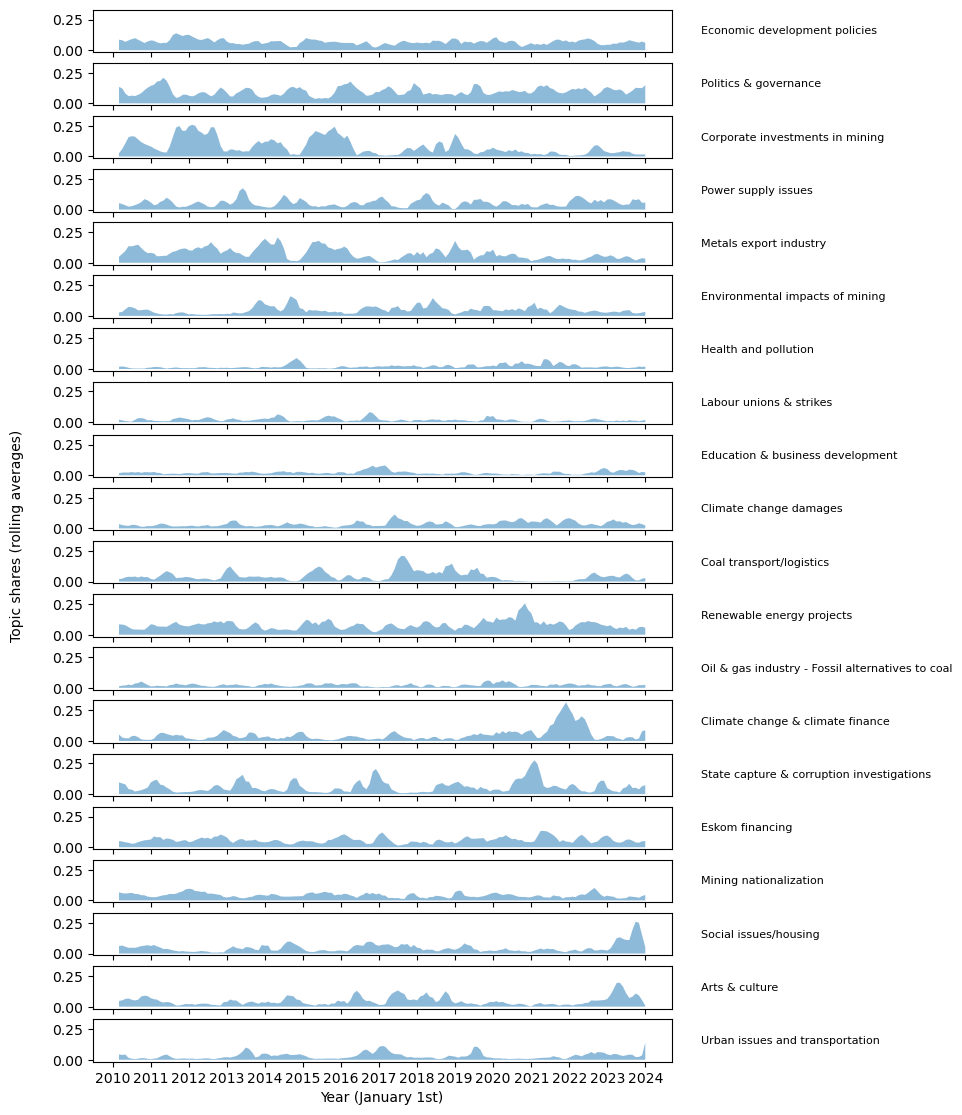

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming topic_names is a dictionary mapping topic indices to topic names
num_topics = len(topic_names)
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1

    # Normalize by number of documents to get the average topic distribution for this time slice
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Rolling averages
window_size = 3  # 12 months for 1 year
rolling_topic_shares = np.array([pd.Series(topic_shares_over_time[:, i]).rolling(window=window_size).mean()
                                 for i in range(num_topics)]).T

# Generate date range from January 2010 to October 2023
dates = pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS')

# Determine the peak year for each topic
peak_years = {}
for topic_idx, topic_name in topic_names.items():
    topic_data = rolling_topic_shares[:, topic_idx]
    # Find the index of the maximum value ignoring NaNs
    peak_index = np.nanargmax(topic_data)
    peak_years[topic_idx] = dates[peak_index].year if peak_index >= 0 else None

# Now print the peak year for each topic
for topic_idx, year in peak_years.items():
    if year is not None:
        print(f"Topic: {topic_names[topic_idx]}, Peak Year: {year}")
    else:
        print(f"Topic: {topic_names[topic_idx]} has no peak year due to insufficient data.")

# Order topics by peak year
ordered_topics = sorted(peak_years.keys(), key=lambda t: peak_years[t])

# Plotting
fig_width = 8.27  # A4 width in inches
fig_height = 11.69  # A4 height in inches
fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(fig_width, fig_height), sharex=True, sharey=True)
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05, hspace=0.25)

for idx, topic_idx in enumerate(ordered_topics):
    ax = axes[idx]
    data = rolling_topic_shares[:, topic_idx]
    ax.fill_between(dates, 0, data, label=topic_names[topic_idx], alpha=0.5)
    ax.text(1.05, 0.5, topic_names[topic_idx], transform=ax.transAxes, va='center', ha='left', fontsize=8)

    # Setting the x-axis for years only
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Set major ticks to every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year

# Set common x-axis labels
axes[-1].set_xlabel('Year (January 1st)')

# Set common y-axis label
fig.text(0.05, 0.5, 'Topic shares (rolling averages)', va='center', rotation='vertical', fontsize=10)

# Save the figure
plt.savefig('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/topic_shares_rolling_average.png', bbox_inches='tight', dpi=300)
plt.show()


Topic Newspaper relations

Loading data...


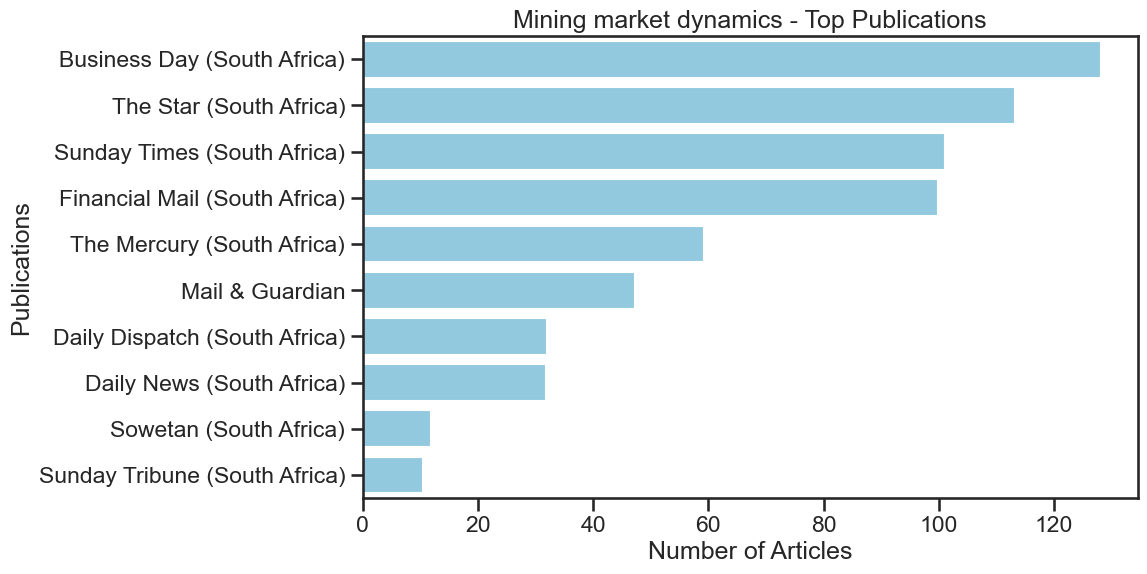

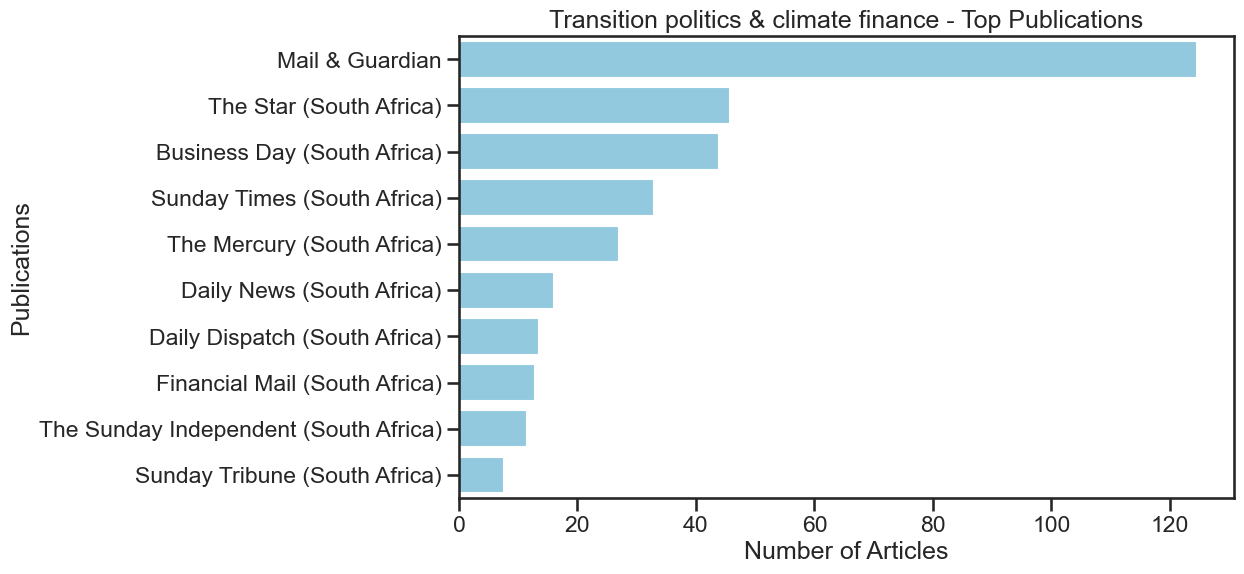

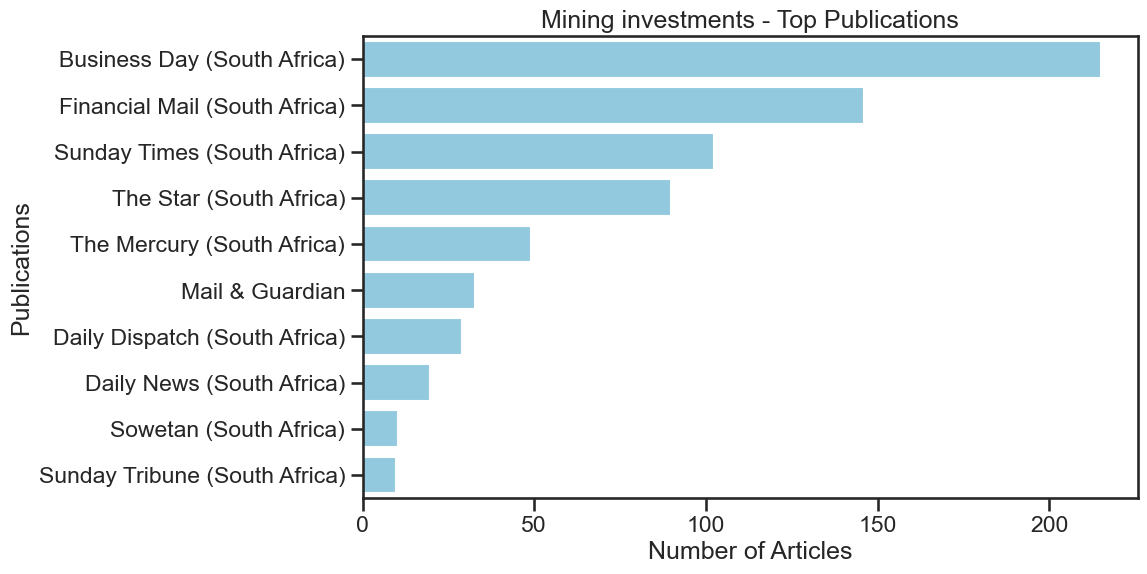

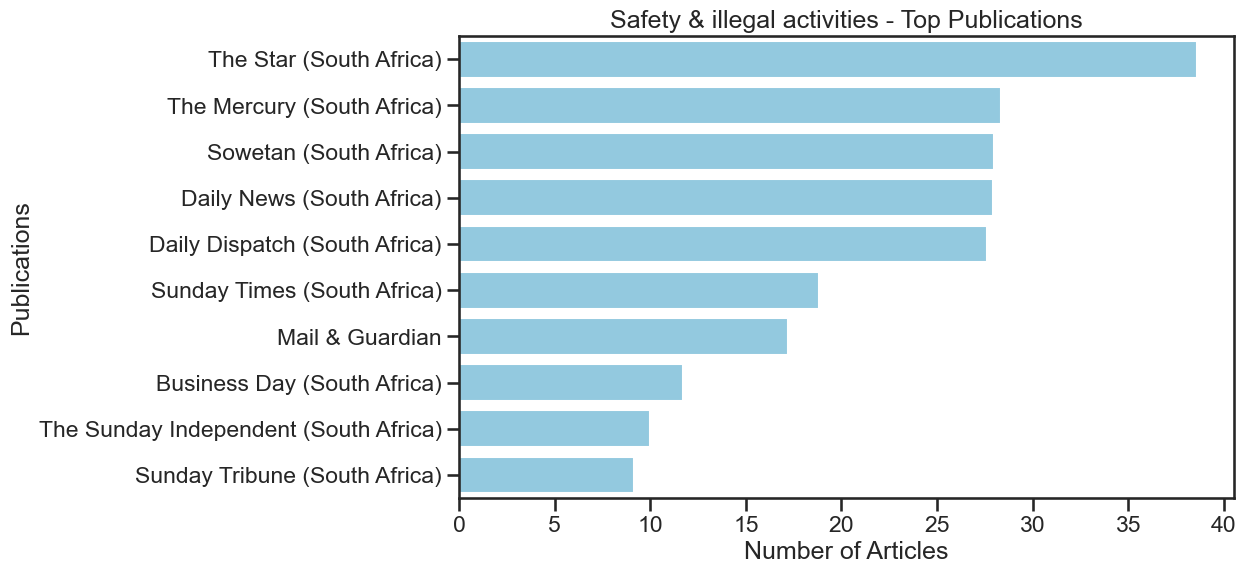

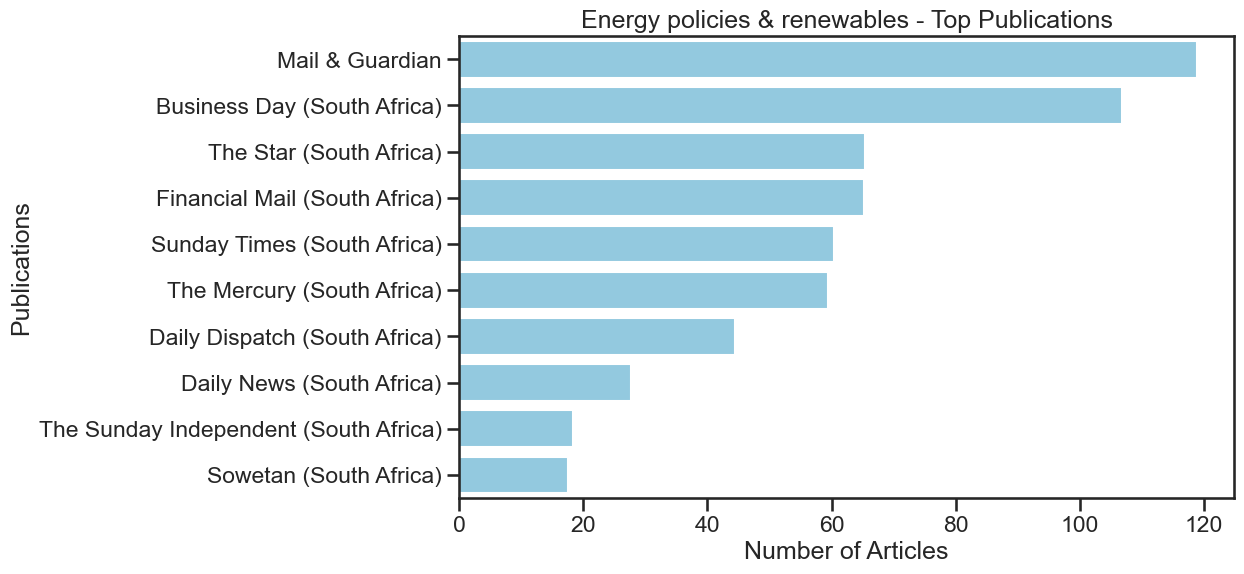

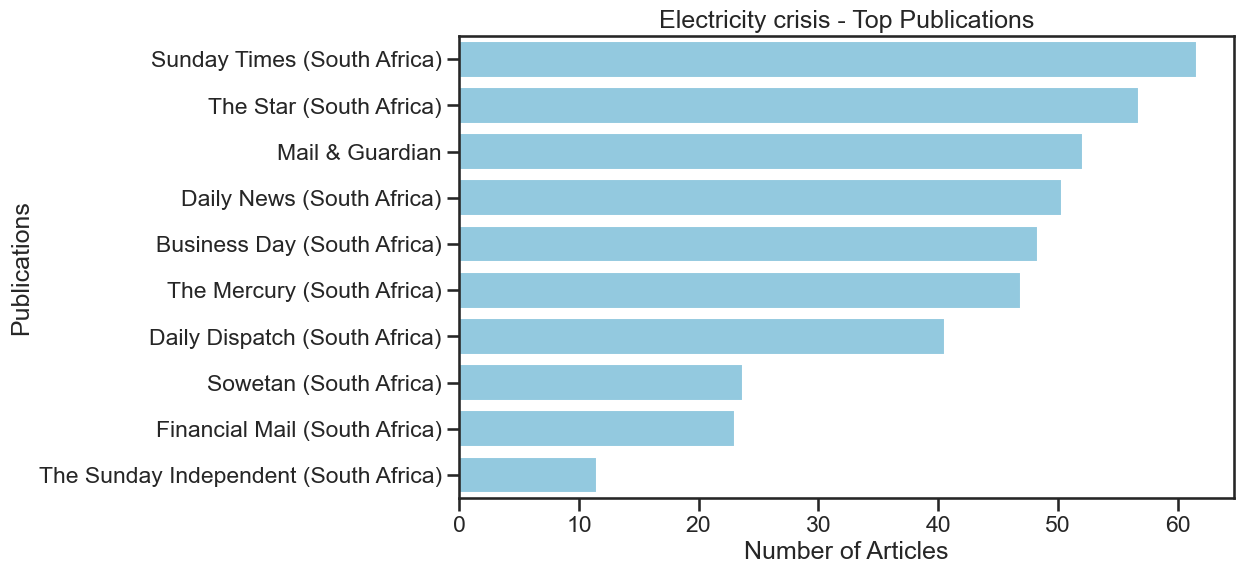

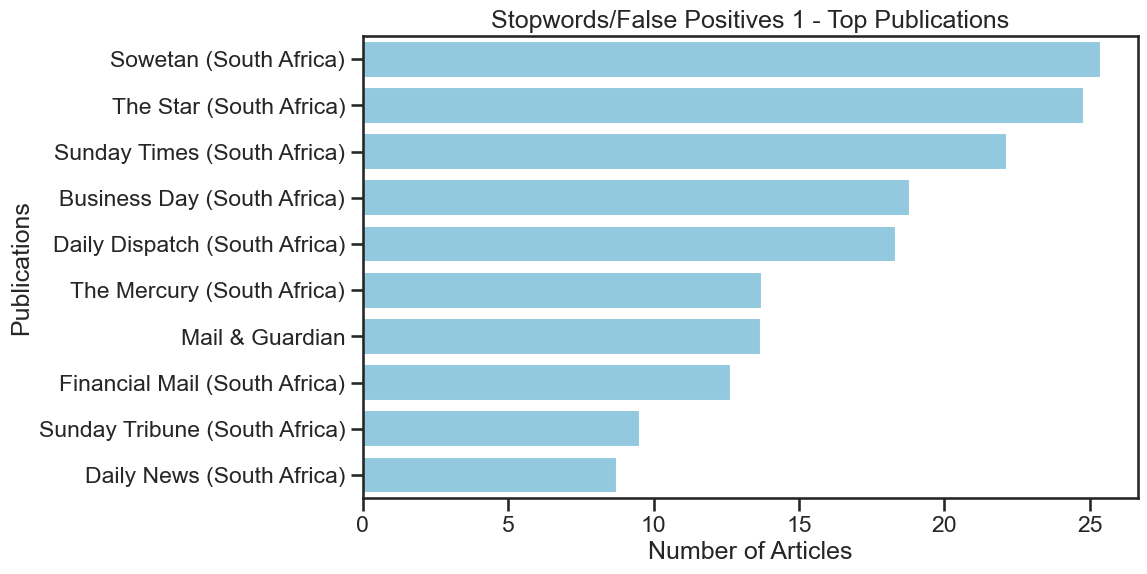

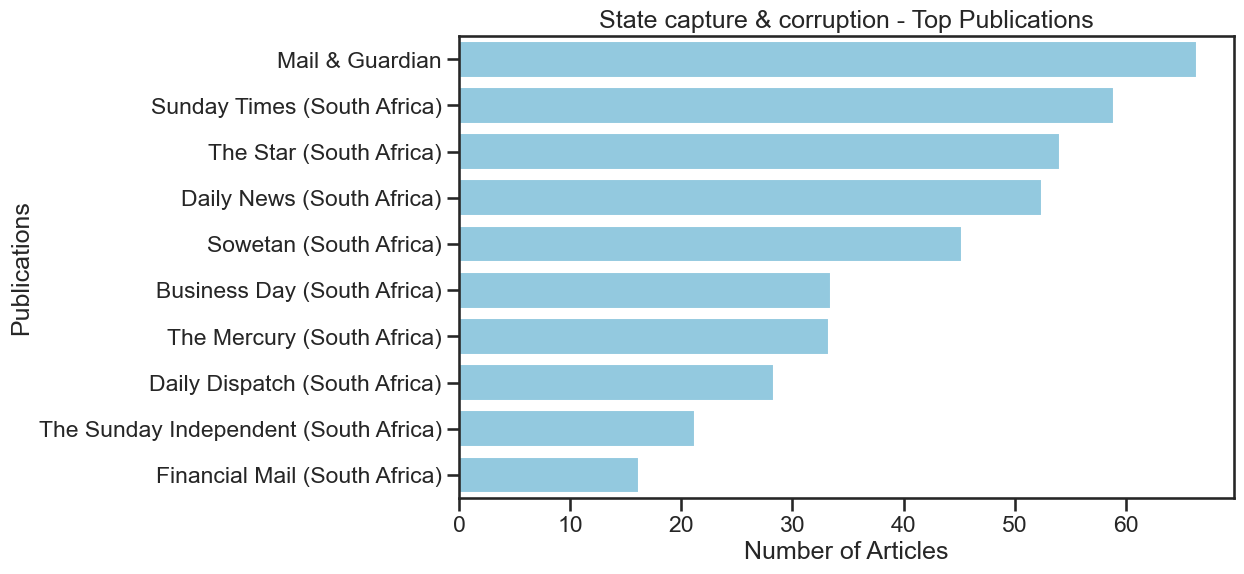

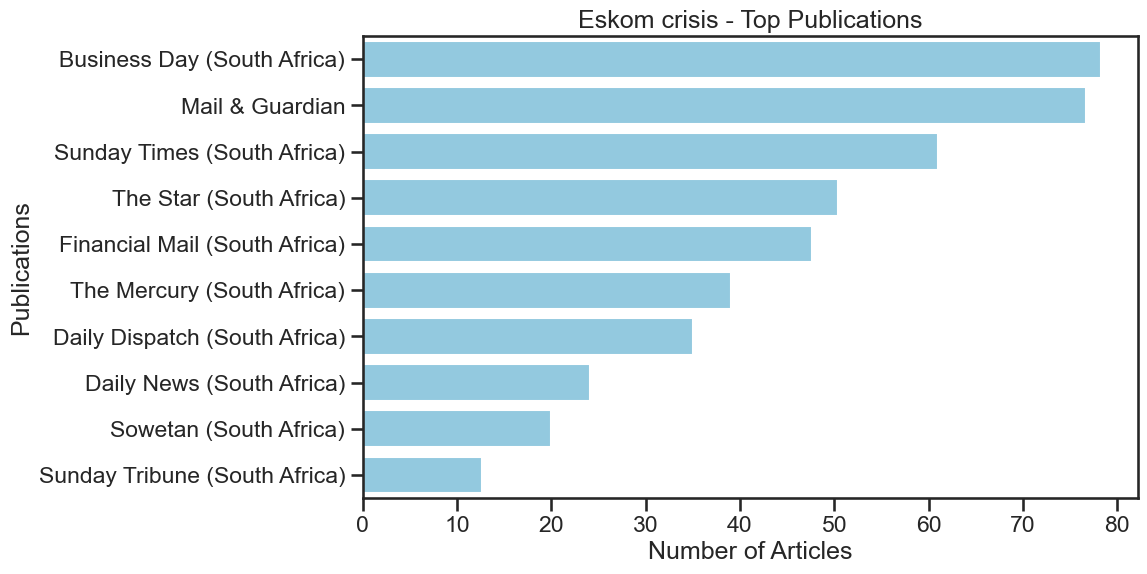

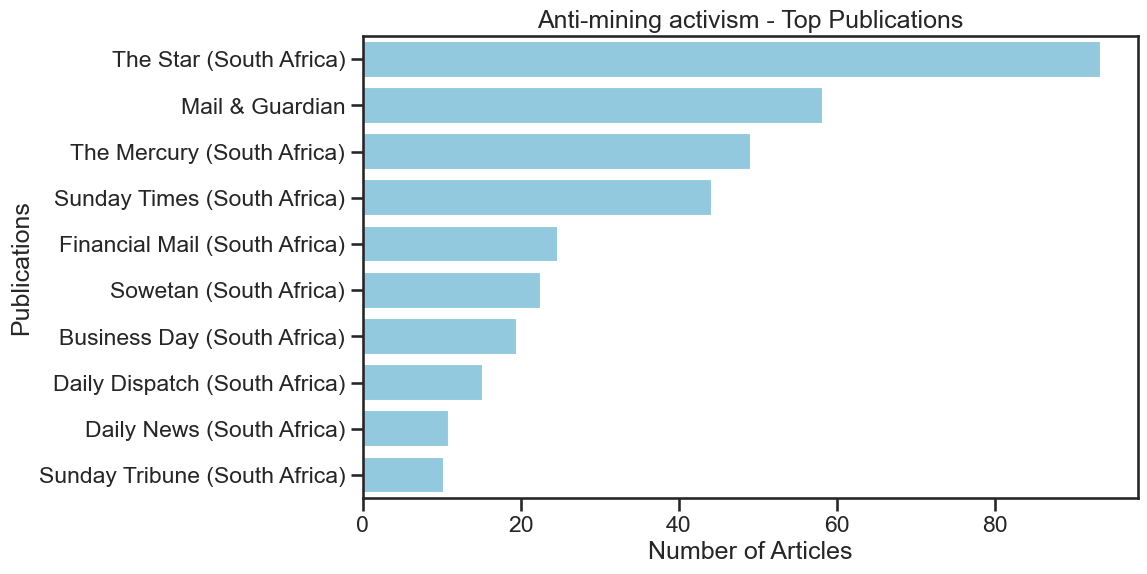

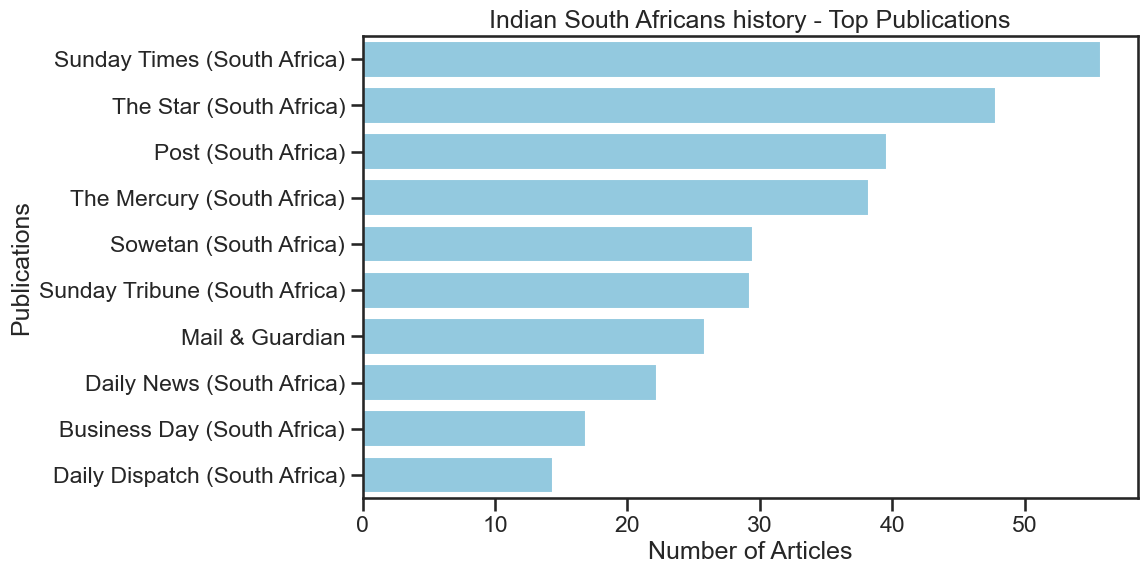

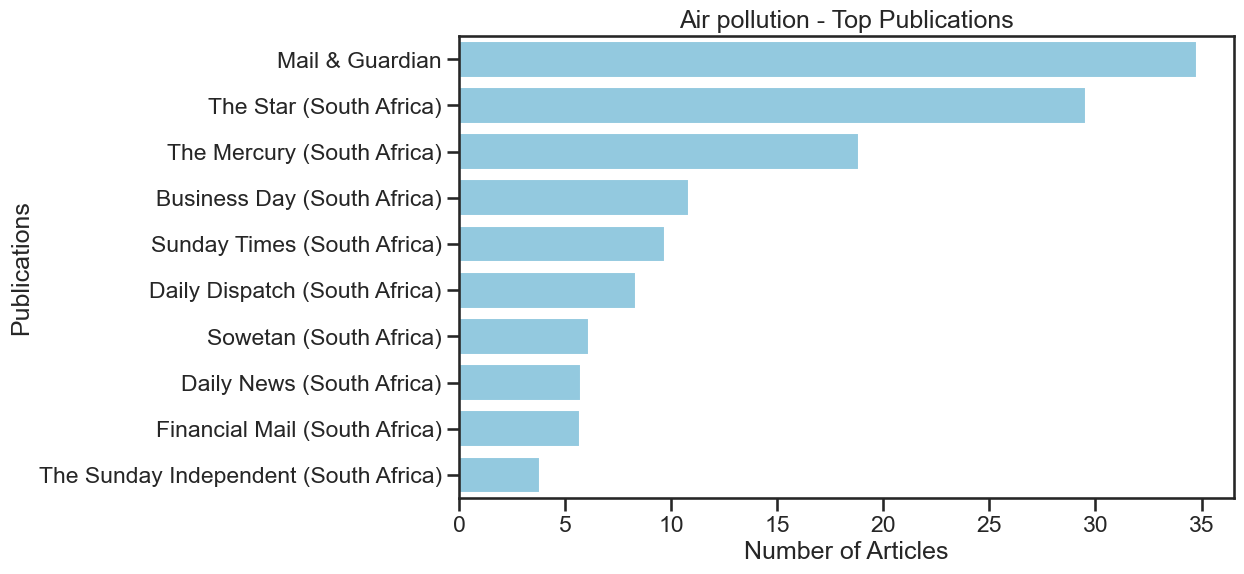

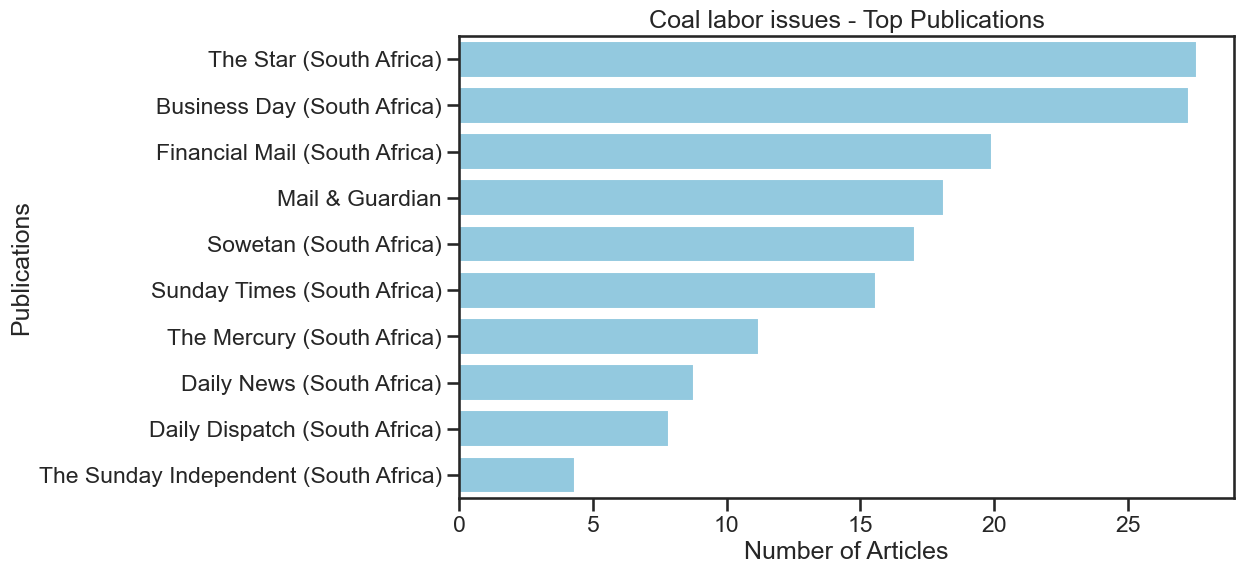

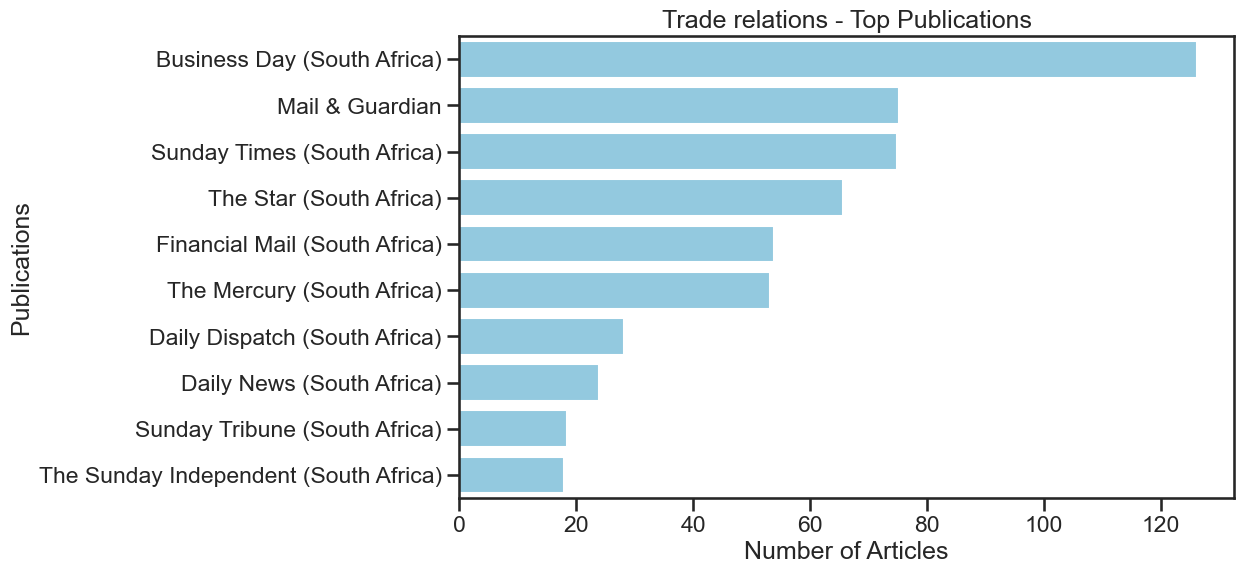

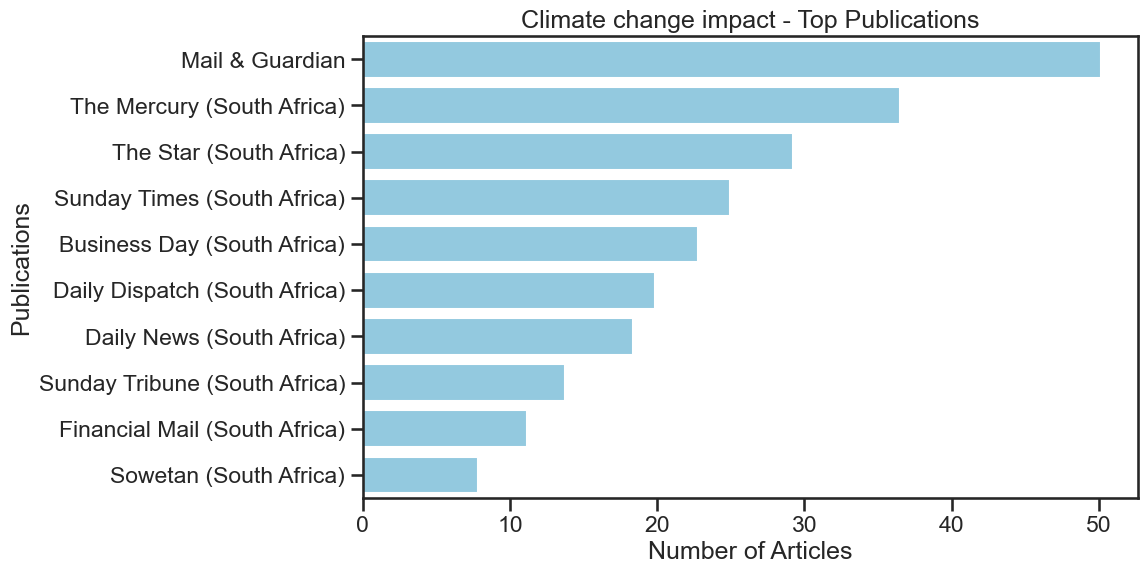

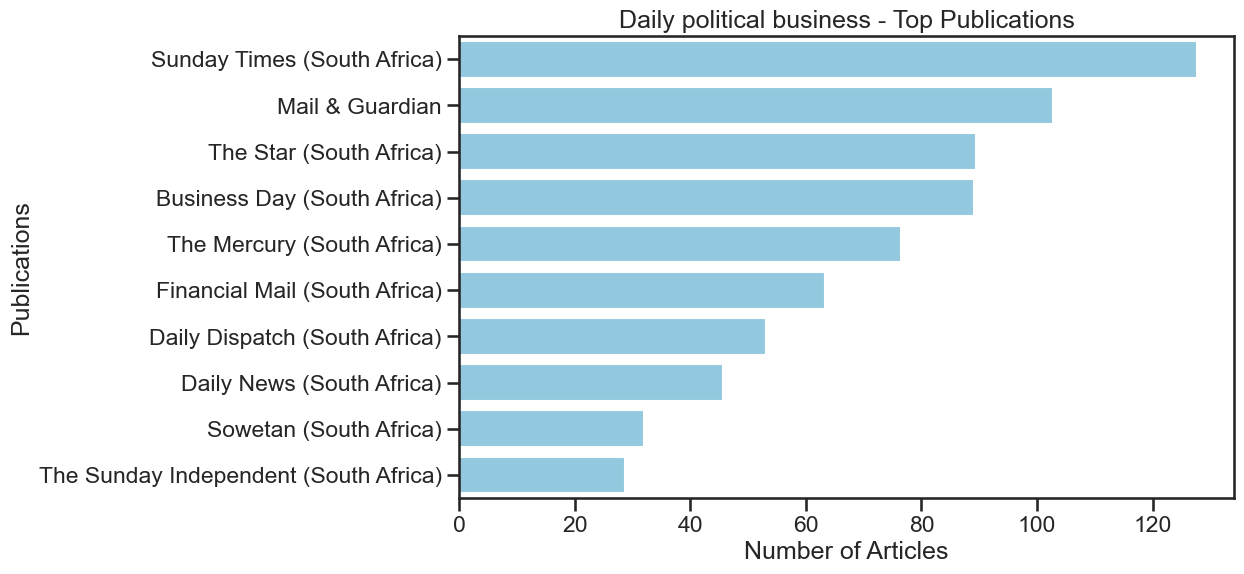

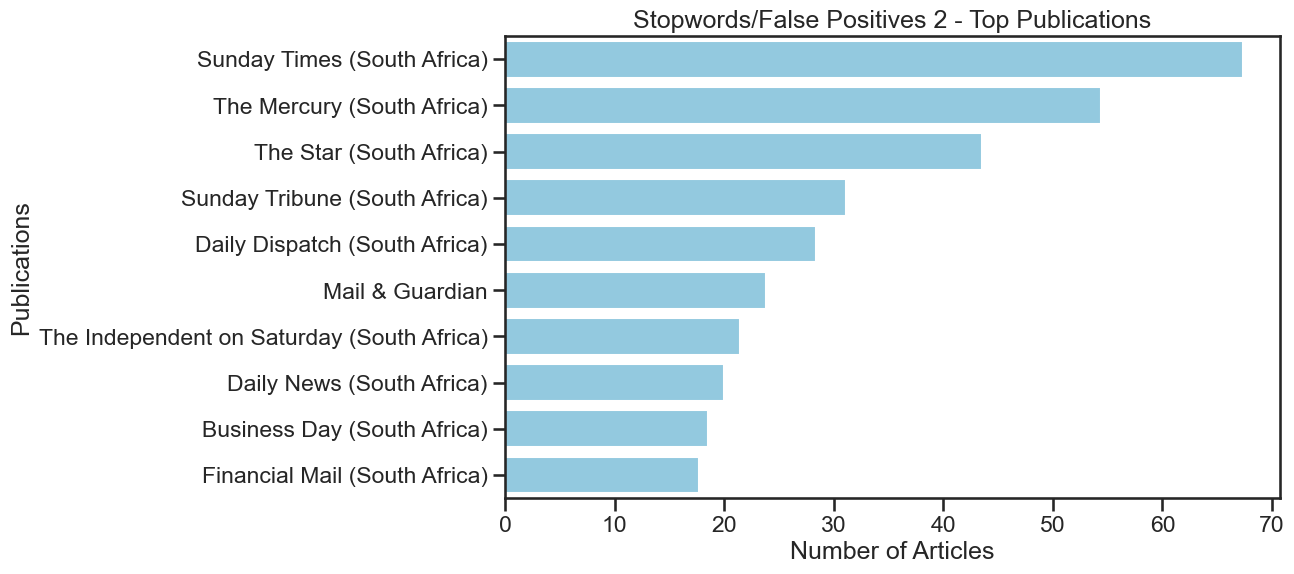

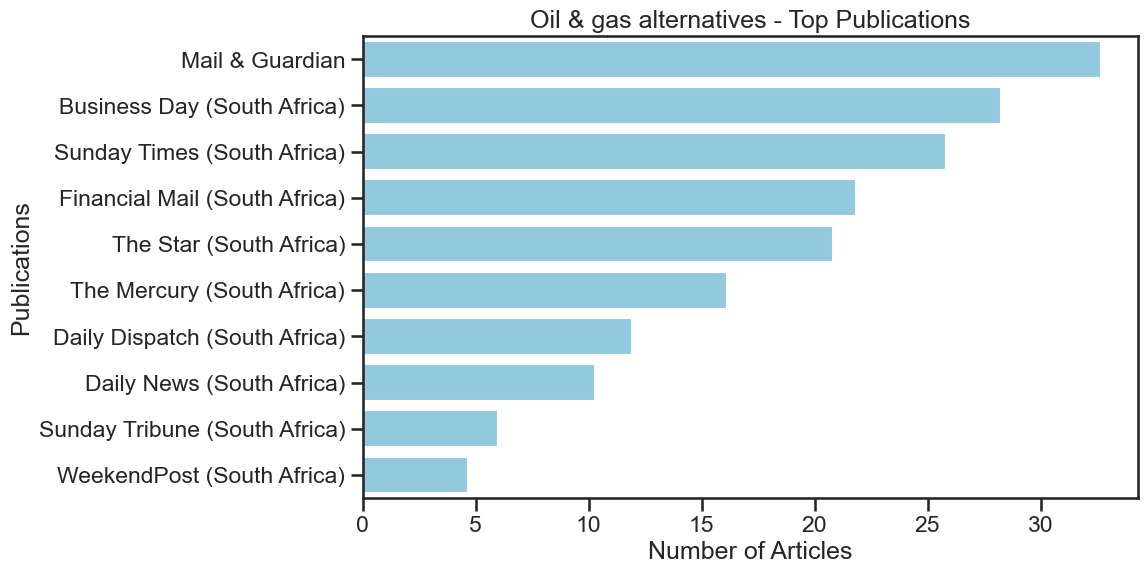

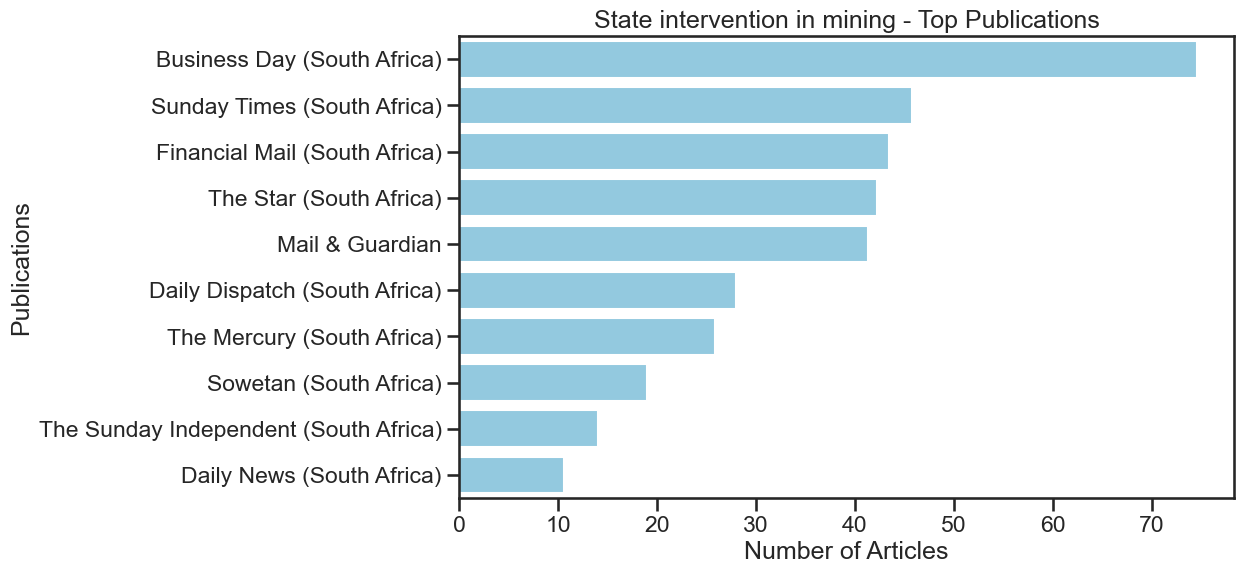

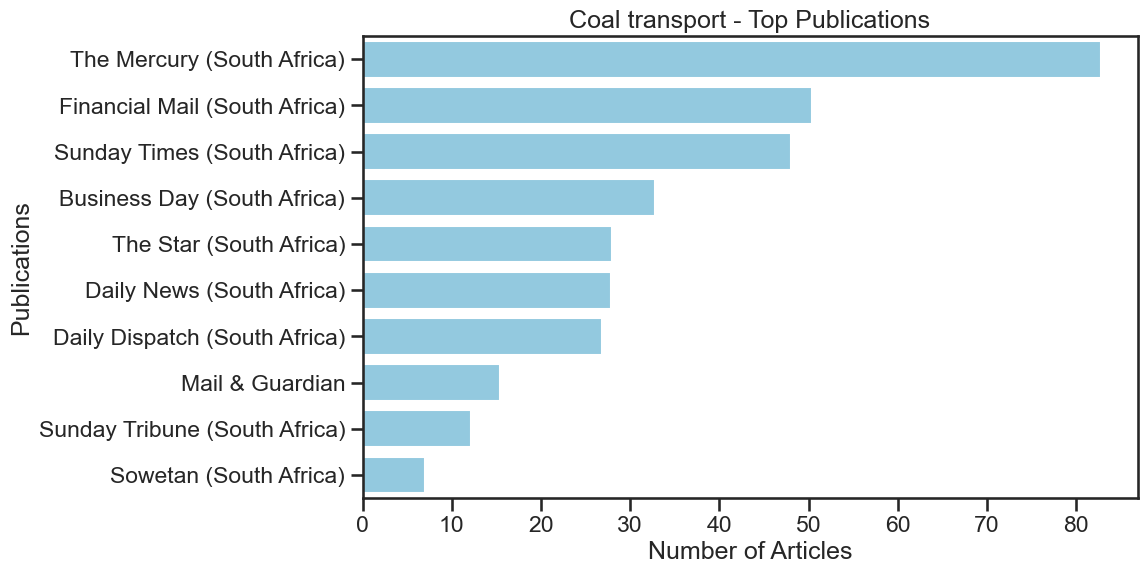

<Figure size 640x480 with 0 Axes>

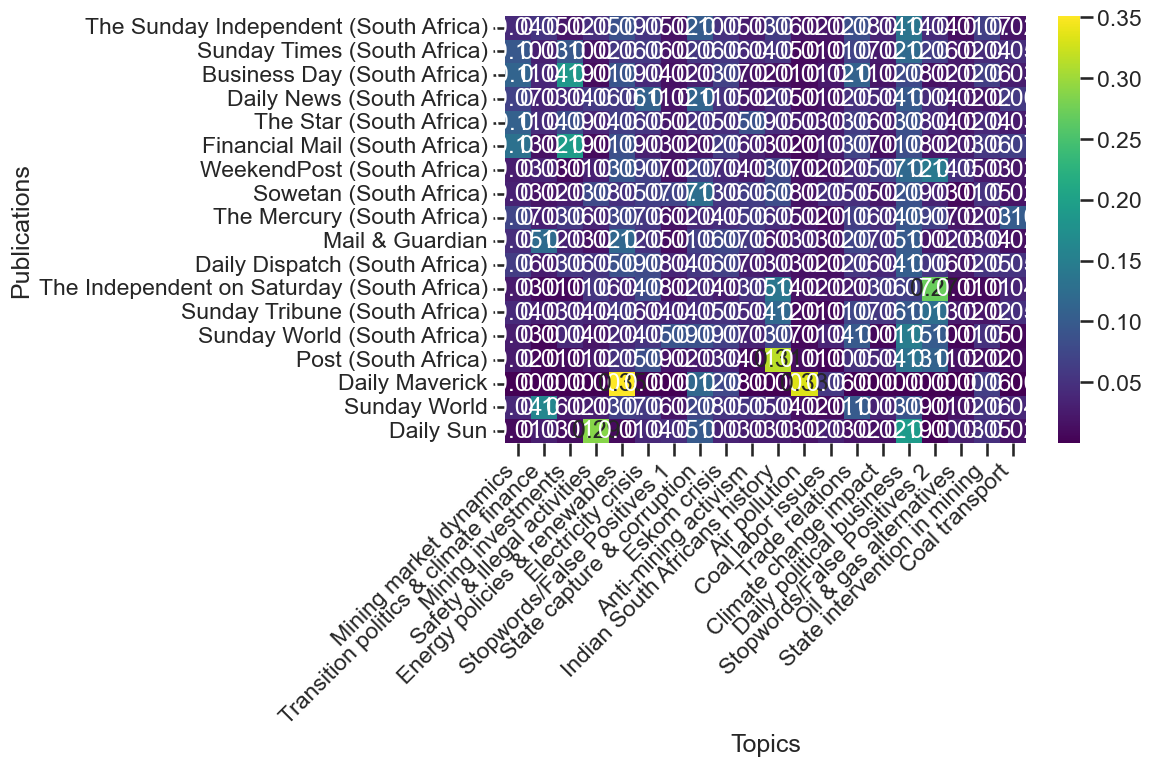

In [12]:
import seaborn as sns

print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])


publications = df['News Outlet'].unique()
topics = [topic_names[i] for i in range(model.gamma_.shape[1])]

topic_contributions = pd.DataFrame(0, index=publications, columns=topics)

# summing up contributions per newspaper
for i, pub in enumerate(df['News Outlet']):
    topic_contributions.loc[pub] += model.gamma_[i]

#normalize the contributions to get relative contributions
topic_contributions_relative = topic_contributions.divide(topic_contributions.sum(axis=1), axis=0)

# save
topic_contributions.to_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/topic_contribution_by_publication2.csv')
topic_contributions_relative.to_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/relative_topic_contribution_by_publication2.csv')


bar_color = 'skyblue'
# bar Chart for each topic showing top publications
for topic in topics:
    plt.figure(figsize=(10, 6))
    top_pubs = topic_contributions[topic].sort_values(ascending=False).head(10)
    sns.barplot(x=top_pubs.values, y=top_pubs.index, color=bar_color)
    plt.title(f'{topic} - Top Publications')
    plt.xlabel('Number of Articles')
    plt.ylabel('Publications')
    plt.show()
plt.savefig('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/publications_bar2.png')

# heatmap of relative contributions
plt.figure(figsize=(12, 8))
sns.heatmap(topic_contributions_relative, annot=True, cmap='viridis', fmt=".2f")
#plt.title('Relative Topic Contributions by Publication')
plt.xlabel('Topics')
plt.ylabel('Publications')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/publications_heatmap2.png')
plt.show()

In [18]:
print(topic_shares_over_time)

[[0.06953182 0.08298715 0.03418385 ... 0.01821462 0.06711117 0.02271121]
 [0.04635536 0.02391756 0.01955629 ... 0.00978349 0.08048933 0.00612762]
 [0.0325831  0.05025463 0.02552388 ... 0.01073755 0.04959671 0.02848118]
 ...
 [0.05225059 0.04890819 0.02654059 ... 0.03493959 0.03437897 0.00839557]
 [0.03627436 0.18241517 0.01442052 ... 0.00222442 0.05551233 0.05467955]
 [0.01195954 0.0278466  0.00735025 ... 0.03787898 0.04105407 0.02458029]]


AttributeError: 'NoneType' object has no attribute 'head'

In [22]:
print(dir(model))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_save_specials', '_smart_save', 'add_lifecycle_event', 'alpha', 'convert_input', 'dtm_coherence', 'dtm_path', 'dtm_vis', 'em_steps', 'fcorpus', 'fcorpustxt', 'fem_steps', 'finit_alpha', 'finit_beta', 'flda_ss', 'fout_gamma', 'fout_influence', 'fout_liklihoods', 'fout_observations', 'fout_prob', 'foutname', 'ftimeslices', 'gamma_', 'id2word', 'influences_time', 'init_alpha', 'init_beta', 'init_ss', 'initialize_lda', 'lambda_', 'lda_max_em_iter', 'lda_sequence_max_iter', 'lda_sequence_min_iter', 'lencorpus', 'lhood_', 'load', 'num_terms', 'num_topics', 'obs_', 'prefix', 'print_topic', 'print_top

In [26]:
print(topic_share_df)

           Time     Topic  Topic_Share
0    2010-01-01   Topic_0     0.069532
1    2010-02-01   Topic_0     0.046355
2    2010-03-01   Topic_0     0.032583
3    2010-04-01   Topic_0     0.138643
4    2010-05-01   Topic_0     0.116842
...         ...       ...          ...
3375 2023-09-01  Topic_19     0.015343
3376 2023-10-01  Topic_19     0.005668
3377 2023-11-01  Topic_19     0.008396
3378 2023-12-01  Topic_19     0.054680
3379 2024-01-01  Topic_19     0.024580

[3380 rows x 3 columns]


Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_1661/2401742484.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


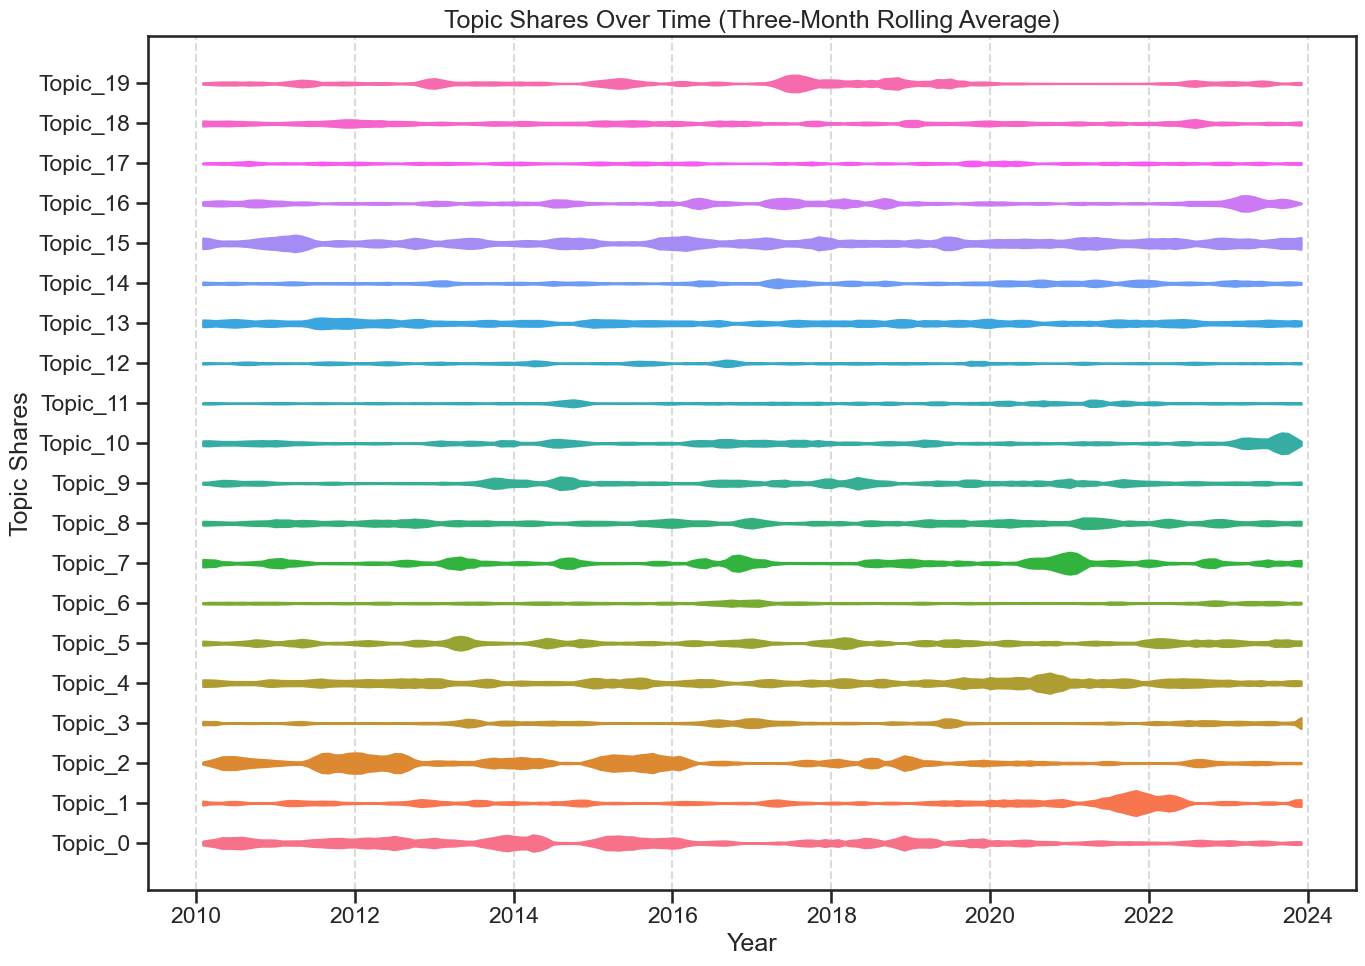

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the model from disk
print("Loading model from disk...")
with open('dtm_model_subset_100_percent.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load preprocessed dataset
print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]

# Initialize variables
num_topics = 20
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

# Calculate topic shares over time
current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    
    # Normalize by number of documents to get the average topic distribution for this time slice
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Create a DataFrame with the time/topic/topic share dimensions
topic_share_df = pd.DataFrame(topic_shares_over_time, index=pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS'))
topic_share_df.columns = [f"Topic_{i}" for i in range(num_topics)]
topic_share_df = topic_share_df.reset_index().melt(id_vars='index', var_name='Topic', value_name='Topic_Share')
topic_share_df.rename(columns={'index': 'Time'}, inplace=True)

# Calculate the three-month rolling average
topic_share_df['Rolling_Avg'] = topic_share_df.groupby('Topic')['Topic_Share'].transform(lambda x: x.rolling(window=3, center=True).mean())

# Plotting each topic's development over time with a three-month rolling average in a mirrored plot
plt.figure(figsize=(14, 10))
topics = topic_share_df['Topic'].unique()
colors = sns.color_palette("husl", len(topics))

for i, topic in enumerate(topics):
    topic_data = topic_share_df[topic_share_df['Topic'] == topic]
    plt.fill_between(topic_data['Time'], topic_data['Rolling_Avg'] + i, i, alpha=1, label=topic, color=colors[i])
    plt.fill_between(topic_data['Time'], i, i - topic_data['Rolling_Avg'], alpha=1, color=colors[i])

plt.yticks(range(len(topics)), topics)
plt.xlabel('Year')
plt.ylabel('Topic Shares')
plt.title('Topic Shares Over Time (Three-Month Rolling Average)')

# Customize the grid and layout
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...
Maximum topic share value: 0.3762460063547391
Normalized Average Class Shares (sums to 1):
Topic_0: 0.0759
Topic_1: 0.0490
Topic_2: 0.0789
Topic_3: 0.0318
Topic_4: 0.0798
Topic_5: 0.0540
Topic_6: 0.0217
Topic_7: 0.0594
Topic_8: 0.0586
Topic_9: 0.0480
Topic_10: 0.0460
Topic_11: 0.0208
Topic_12: 0.0192
Topic_13: 0.0680
Topic_14: 0.0361
Topic_15: 0.0979
Topic_16: 0.0463
Topic_17: 0.0223
Topic_18: 0.0421
Topic_19: 0.0442


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_3514/263143831.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


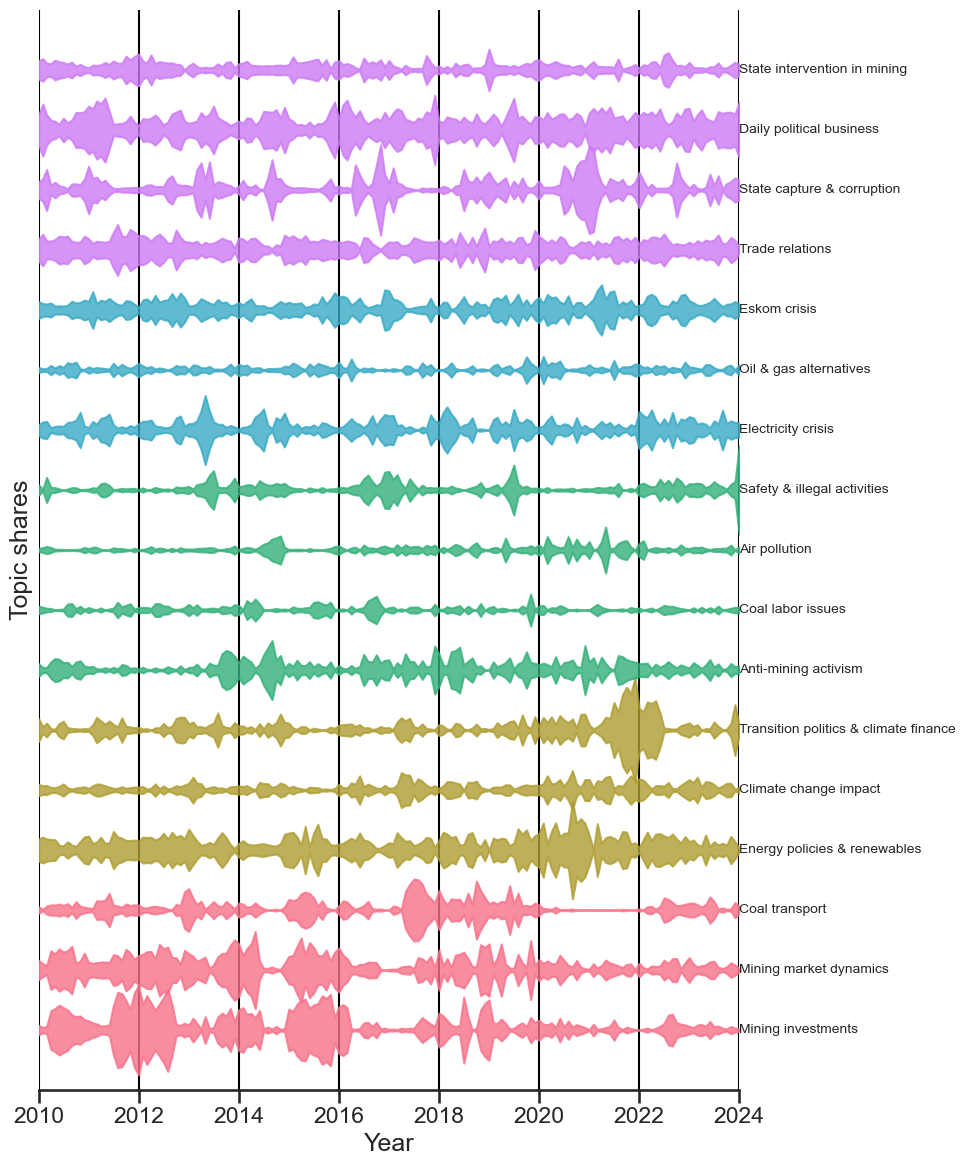

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# load model from disk
print("Loading model from disk...")
with open('dtm_model_subset_100_percent.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# load preprocessed dataset
print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts().get(period, 0) for period in sorted(df['YearMonth'].unique())]

# Initialize variables
num_topics = 20
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

# Calculate topic shares over time
current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    if num_docs > 0:
        topic_shares_over_time[time_slice_index, :] /= num_docs

# Find the single highest topic share value
max_topic_share = np.max(topic_shares_over_time)
print(f"Maximum topic share value: {max_topic_share}")

# Normalize the topic shares to a maximum of 25%
normalized_topic_shares = (topic_shares_over_time / max_topic_share) * max_topic_share

# Create a DataFrame with the time/topic/topic share dimensions
topic_share_df = pd.DataFrame(normalized_topic_shares, index=pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS'))
topic_share_df.columns = [f"Topic_{i}" for i in range(num_topics)]
topic_share_df = topic_share_df.reset_index().melt(id_vars='index', var_name='Topic', value_name='Topic_Share')
topic_share_df.rename(columns={'index': 'Time'}, inplace=True)

# Calculate the three-month rolling average
topic_share_df['Rolling_Avg'] = topic_share_df.groupby('Topic')['Topic_Share'].transform(lambda x: x.rolling(window=3, center=True).mean())
topics = topic_share_df['Topic'].unique()

# Define topic classifications
topic_names = {
    0:  "Mining market dynamics",                # Mining Industry
    1:  "Transition politics & climate finance", # Climate change & Transition Politics
    2:  "Mining investments",                    # Mining Industry
    3:  "Safety & illegal activities",           # Mining Communities
    4:  "Energy policies & renewables",          # Climate change & Transition Politics / Energy Crisis
    5:  "Electricity crisis",                    # Energy Crisis
    6:  "Stopwords/False Positives 1",           # Don't Display
    7:  "State capture & corruption",            # State Role in Mining
    8:  "Eskom crisis",                          # Energy Crisis
    9:  "Anti-mining activism",                  # Mining Communities / Climate change & Transition Politics
    10: "Indian South Africans history",         # Don't Display
    11: "Air pollution",                         # Mining Communities
    12: "Coal labor issues",                     # Mining Communities
    13: "Trade relations",                       # State Role in Mining 
    14: "Climate change impact",                 # Climate change & Transition Politics
    15: "Daily political business",              # State Role in Mining
    16: "Stopwords/False Positives 2",           # Don't Display
    17: "Oil & gas alternatives",                # Energy Crisis
    18: "State intervention in mining",          # State Role in Mining
    19: "Coal transport"                         # Mining Industry
}


topic_classes = {
    "Mining industry": ["Mining market dynamics", "Mining investments", "Coal transport"],
    "Transition politics": ["Transition politics & climate finance", "Energy policies & renewables", "Climate change impact"],
    "Mining affected communities": ["Safety & illegal activities", "Anti-mining activism", "Air pollution",  "Coal labor issues"],
    "Energy crisis": ["Electricity crisis", "Eskom crisis", "Oil & gas alternatives"],
    "Politics in mining & energy": ["State capture & corruption", "Daily political business", "State intervention in mining", "Trade relations"],
    "Don't Display": ["Stopwords/False Positives 1", "Indian South Africans history", "Stopwords/False Positives 2"]
}

# Filter out topics to be displayed
display_topics = {k: v for k, v in topic_names.items() if v not in topic_classes["Don't Display"]}

# This is only done for the plot on labeling!
average_topic_shares = topic_shares_over_time.mean(axis=0).tolist()

# Normalize average class shares so they sum to 1
total_share = sum(average_topic_shares)
normalized_average_topic_shares = {f"Topic_{i}": share / total_share for i, share in enumerate(average_topic_shares)}
# Print average class shares
print("Normalized Average Class Shares (sums to 1):")
for cls, share in normalized_average_topic_shares.items():
    print(f"{cls}: {share:.4f}")


# Get peak years for each topic
peak_years = {}
for topic_idx in range(num_topics):
    if topic_names[topic_idx] not in display_topics.values():
        continue
    topic_data = topic_share_df[topic_share_df['Topic'] == f"Topic_{topic_idx}"]
    rolling_avg = topic_data['Rolling_Avg'].values
    peak_index = np.nanargmax(rolling_avg)
    peak_years[f"Topic_{topic_idx}"] = topic_data.iloc[peak_index]['Time'].year if peak_index is not None and not np.isnan(peak_index) else None

# Order topics by class and peak year
ordered_topics = []
for topic_class, topics in topic_classes.items():
    if topic_class == "Don't Display":
        continue
    class_topics = [k for k, v in display_topics.items() if v in topics]
    class_topics_sorted = sorted(class_topics, key=lambda x: peak_years.get(f"Topic_{x}", pd.Timestamp('2100-01-01')))
    ordered_topics.extend(class_topics_sorted)

# Plotting each topic's development over time with a three-month rolling average
sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid': True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False,
               'grid.color': 'k',
               'grid.linewidth': 1})
sns.set_palette('husl', 5)

fig, ax = plt.subplots(1, figsize=(10, 12))

max_val = 0.43  # Maximum value for topic shares
y_max = len(ordered_topics) * max_val

# Assign colors to each class
class_colors = sns.color_palette("husl", len(topic_classes) - 1)  # Excluding "Don't Display"
class_color_map = {topic_class: color for topic_class, color in zip([k for k in topic_classes.keys() if k != "Don't Display"], class_colors)}

for i, topic_idx in enumerate(ordered_topics):
    topic_data = topic_share_df[topic_share_df['Topic'] == f"Topic_{topic_idx}"].dropna(subset=['Rolling_Avg'])
    topic_name = display_topics[topic_idx]
    topic_class = next(key for key, value in topic_classes.items() if topic_name in value)
    
    ax.fill_between(topic_data['Time'], topic_data['Rolling_Avg'] + i * max_val, i * max_val - topic_data['Rolling_Avg'],
                    color=class_color_map[topic_class], alpha=0.8)
    ax.text(pd.Timestamp('2024-01-01'), i * max_val, topic_name, fontsize=10, va='center', ha='left')

ax.set_yticks([])
ax.set_xlabel('Year')
ax.set_ylabel('Topic shares')
ax.set_xlim([pd.Timestamp('2010-01-01'), pd.Timestamp('2024-01-01')])
ax.set_ylim([-max_val, y_max])
ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2010, 2025, 2)])
ax.set_xticklabels([str(year) for year in range(2010, 2025, 2)])

plt.tight_layout()
#plt.savefig('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/topic_development3.png')

plt.show()


Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...
Maximum topic share value: 0.3762460063547391


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_2823/3718466309.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


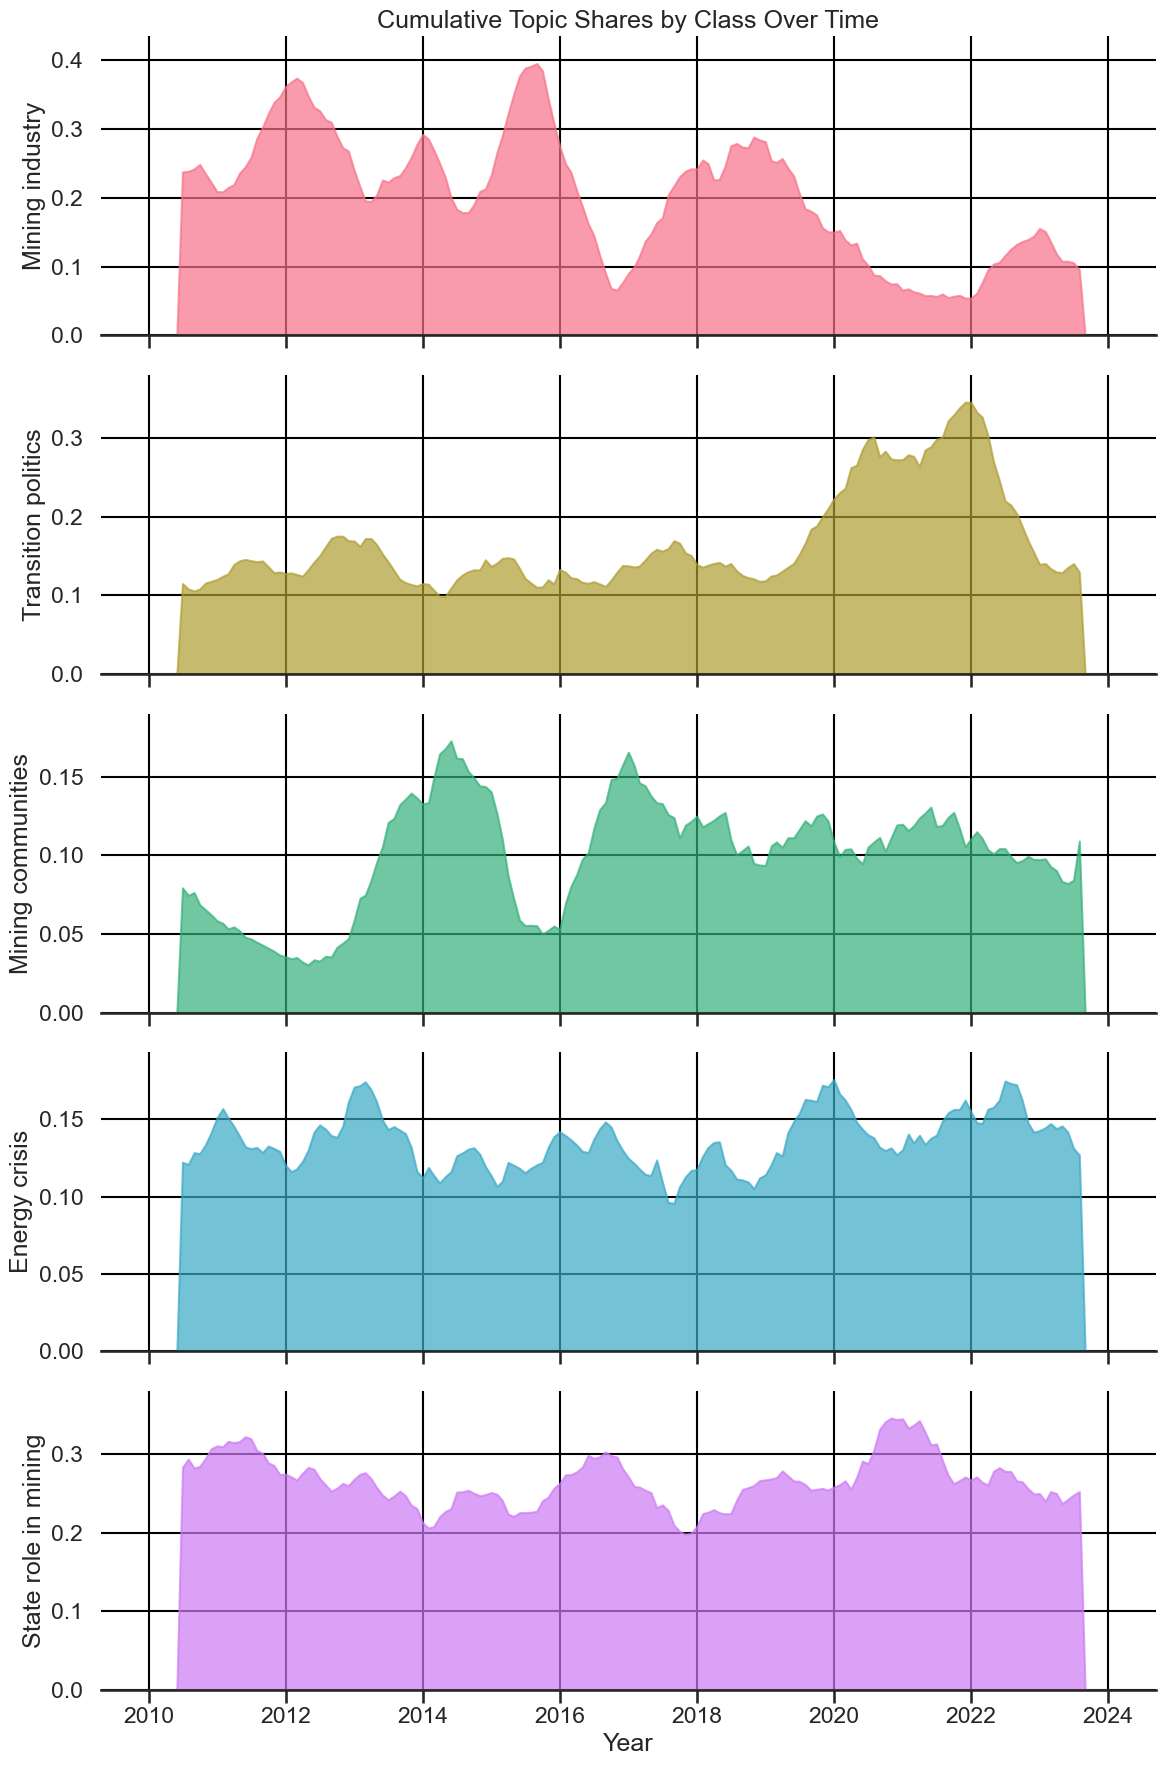

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# load the model
print("Loading model from disk...")
with open('dtm_model_subset_100_percent.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# preprocessed dataset
print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts().get(period, 0) for period in sorted(df['YearMonth'].unique())]

# Initialize variables
num_topics = 20
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

# Calculate topic shares over time
current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    if num_docs > 0:
        topic_shares_over_time[time_slice_index, :] /= num_docs

# Find the single highest topic share value
max_topic_share = np.max(topic_shares_over_time)
print(f"Maximum topic share value: {max_topic_share}")

# Normalize the topic shares to a maximum of 25%
normalized_topic_shares = (topic_shares_over_time / max_topic_share) * max_topic_share

# Create a DataFrame with the time/topic/topic share dimensions
topic_share_df = pd.DataFrame(normalized_topic_shares, index=pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS'))
topic_share_df.columns = [f"Topic_{i}" for i in range(num_topics)]
topic_share_df = topic_share_df.reset_index().melt(id_vars='index', var_name='Topic', value_name='Topic_Share')
topic_share_df.rename(columns={'index': 'Time'}, inplace=True)

# Calculate the three-month rolling average
topic_share_df['Rolling_Avg'] = topic_share_df.groupby('Topic')['Topic_Share'].transform(lambda x: x.rolling(window=12, center=True).mean())
topics = topic_share_df['Topic'].unique()

# Define topic classifications
topic_names = {
    0:  "Mining market dynamics",                # Mining Industry
    1:  "Transition politics & climate finance", # Climate change & Transition Politics
    2:  "Mining investments",                    # Mining Industry
    3:  "Safety & illegal activities",           # Mining Communities
    4:  "Energy policies & renewables",          # Climate change & Transition Politics / Energy Crisis
    5:  "Electricity crisis",                    # Energy Crisis
    6:  "Stopwords/False Positives 1",           # Don't Display
    7:  "State capture & corruption",            # State Role in Mining
    8:  "Eskom crisis",                          # Energy Crisis
    9:  "Anti-mining activism",                  # Mining Communities / Climate change & Transition Politics
    10: "Indian South Africans history",         # Don't Display
    11: "Air pollution",                         # Mining Communities
    12: "Coal labor issues",                     # Mining Communities
    13: "Trade relations",                       # State Role in Mining
    14: "Climate change impact",                 # Climate change & Transition Politics
    15: "Daily political business",              # State Role in Mining
    16: "Stopwords/False Positives 2",           # Don't Display
    17: "Oil & gas alternatives",                # Energy Crisis
    18: "State intervention in mining",          # State Role in Mining
    19: "Coal transport"                         # Mining Industry
}


topic_classes = {
    "Mining industry": ["Mining market dynamics", "Mining investments", "Coal labor lssues", "Coal transport"],
    "Transition politics": ["Transition politics & climate finance", "Energy policies & renewables", "Climate change impact"],
    "Mining communities": ["Safety & illegal activities", "Anti-mining activism", "Air pollution"],
    "Energy crisis": ["Electricity crisis", "Eskom crisis", "Oil & gas alternatives"],
    "State role in mining": ["State capture & corruption", "Daily political business", "State intervention in mining", "Trade relations"],
    "Don't Display": ["Stopwords/False Positives 1", "Indian South Africans history", "Stopwords/False Positives 2"]
}


# Filter out topics to be displayed
display_topics = {k: v for k, v in topic_names.items() if v not in topic_classes.get("Don't Display", [])}

# Calculate cumulative topic shares for each class over time
class_shares = {cls: np.zeros(len(time_slices)) for cls in topic_classes if cls != "Don't Display"}

for topic_idx, topic_name in display_topics.items():
    topic_class = next((cls for cls, topics in topic_classes.items() if topic_name in topics), None)
    if topic_class:
        topic_data = topic_share_df[topic_share_df['Topic'] == f"Topic_{topic_idx}"]['Rolling_Avg'].values
        class_shares[topic_class] += np.nan_to_num(topic_data)

# Plotting cumulative topic shares for each class
sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid': True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False,
               'grid.color': 'k',
               'grid.linewidth': 1})
sns.set_palette('husl', 5)

fig, axes = plt.subplots(len(class_shares), 1, figsize=(12, 18), sharex=True)

class_colors = sns.color_palette("husl", len(class_shares))

for ax, (topic_class, shares) in zip(axes, class_shares.items()):
    ax.fill_between(pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS'), shares, color=class_colors.pop(0), alpha=0.7)
    ax.set_ylabel(topic_class)
    ax.set_ylim(0, max(shares) * 1.1)

axes[-1].set_xlabel('Year')
axes[0].set_title('Cumulative Topic Shares by Class Over Time')

plt.tight_layout()
plt.show()


Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...
Normalized Average Class Shares (sums to 1):
Mining industry: 0.2255
Transition politics: 0.1846
Mining affected communities: 0.1355
Energy crisis: 0.1527
Politics in mining & energy: 0.3017


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_4196/3779639325.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


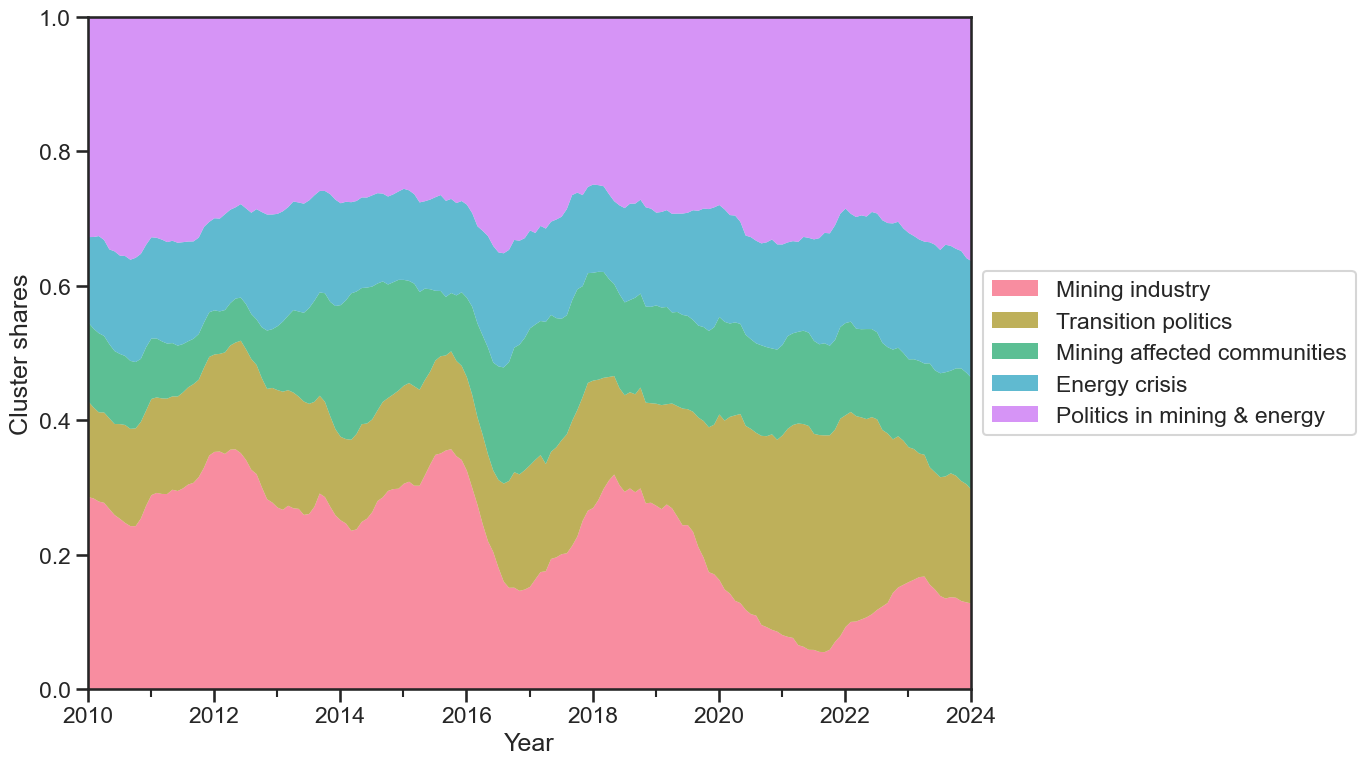

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the model from disk
print("Loading model from disk...")
with open('dtm_model_subset_100_percent.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load the preprocessed dataset
print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts().get(period, 0) for period in sorted(df['YearMonth'].unique())]

# Initialize variables
num_topics = 20
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

# Calculate topic shares over time
current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    if num_docs > 0:
        topic_shares_over_time[time_slice_index, :] /= num_docs

# Normalize topic shares so that each row sums to 1
normalized_topic_shares = topic_shares_over_time / topic_shares_over_time.sum(axis=1, keepdims=True)

# Create a DataFrame with the time/topic/topic share dimensions
topic_share_df = pd.DataFrame(normalized_topic_shares, index=pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS'))
topic_share_df.columns = [f"Topic_{i}" for i in range(num_topics)]
topic_share_df = topic_share_df.reset_index().melt(id_vars='index', var_name='Topic', value_name='Topic_Share')
topic_share_df.rename(columns={'index': 'Time'}, inplace=True)

# Calculate the three-month rolling average
topic_share_df['Rolling_Avg'] = topic_share_df.groupby('Topic')['Topic_Share'].transform(lambda x: x.rolling(window=18, min_periods=1, center=True).mean())
topics = topic_share_df['Topic'].unique()

# Define topic classifications
topic_names = {
    0:  "Mining market dynamics",                # Mining Industry
    1:  "Transition politics & climate finance", # Climate change & Transition Politics
    2:  "Mining investments",                    # Mining Industry
    3:  "Safety & illegal activities",           # Mining Communities
    4:  "Energy policies & renewables",          # Climate change & Transition Politics / Energy Crisis
    5:  "Electricity crisis",                    # Energy Crisis
    6:  "Stopwords/False Positives 1",           # Don't Display
    7:  "State capture & corruption",            # State Role in Mining
    8:  "Eskom crisis",                          # Energy Crisis
    9:  "Anti-mining activism",                  # Mining Communities / Climate change & Transition Politics
    10: "Indian South Africans history",         # Don't Display
    11: "Air pollution",                         # Mining Communities
    12: "Coal labor issues",                     # Mining Industry
    13: "Trade relations",                  # Mining Communities
    14: "Climate change impact",                 # Climate change & Transition Politics
    15: "Daily political business",              # State Role in Mining
    16: "Stopwords/False Positives 2",           # Don't Display
    17: "Oil & gas alternatives",                # Energy Crisis
    18: "State intervention in mining",          # State Role in Mining
    19: "Coal transport"                         # Mining Industry
}


topic_classes = {
    "Mining industry": ["Mining market dynamics", "Mining investments", "Coal transport"],
    "Transition politics": ["Transition politics & climate finance", "Energy policies & renewables", "Climate change impact"],
    "Mining affected communities": ["Safety & illegal activities", "Anti-mining activism", "Air pollution",  "Coal labor issues"],
    "Energy crisis": ["Electricity crisis", "Eskom crisis", "Oil & gas alternatives"],
    "Politics in mining & energy": ["State capture & corruption", "Daily political business", "State intervention in mining", "Trade relations"],
    "Don't Display": ["Stopwords/False Positives 1", "Indian South Africans history", "Stopwords/False Positives 2"]
}


# Filter out topics to be displayed
display_topics = {k: v for k, v in topic_names.items() if v not in topic_classes.get("Don't Display", [])}

# Calculate cumulative topic shares for each class over time
class_shares = {cls: np.zeros(len(time_slices)) for cls in topic_classes if cls != "Don't Display"}

for topic_idx, topic_name in display_topics.items():
    topic_class = next((cls for cls, topics in topic_classes.items() if topic_name in topics), None)
    if topic_class:
        topic_data = topic_share_df[topic_share_df['Topic'] == f"Topic_{topic_idx}"]['Rolling_Avg'].values
        class_shares[topic_class] += np.nan_to_num(topic_data)

# Normalize class shares so they sum to 1 for each time period
class_shares_df = pd.DataFrame(class_shares, index=pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS'))
class_shares_df = class_shares_df.div(class_shares_df.sum(axis=1), axis=0)

# Define colors for each class using sns.color_palette("husl", 5)
class_colors = sns.color_palette("husl", len(class_shares))
class_color_map = {cls: color for cls, color in zip(class_shares.keys(), class_colors)}

# This is only done for the actor plot!
# Calculate average class shares over all periods
average_class_shares = class_shares_df.mean().to_dict()

# Normalize average class shares so they sum to 1
total_share = sum(average_class_shares.values())
normalized_average_class_shares = {k: v / total_share for k, v in average_class_shares.items()}

# Print average class shares
print("Normalized Average Class Shares (sums to 1):")
for cls, share in normalized_average_class_shares.items():
    print(f"{cls}: {share:.4f}")


# Plotting cumulative topic shares for each class as an area chart
sns.set_context("talk")
sns.set_style("ticks")

fig, ax = plt.subplots(1, figsize=(14, 8))

class_shares_df.plot.area(ax=ax, linewidth=0, alpha=0.8, color=[class_color_map[cls] for cls in class_shares_df.columns])

ax.set_xlabel('Year')
ax.set_ylabel('Cluster shares')
ax.set_xlim([pd.Timestamp('2010-01-01'), pd.Timestamp('2024-01-01')])
ax.set_ylim([0, 1])
ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2010, 2025, 2)])
ax.set_xticklabels([str(year) for year in range(2010, 2025, 2)])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title=None)

#plt.title('Cumulative topic class shares over time')
plt.tight_layout()
plt.savefig('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Text-Tables/area_chart_topic_cluster3.png')
plt.show()
